In [1]:
## Load packages
library(readxl)
library(stringr)
library(rentrez)
library(dplyr)
library(tidyr)
library(ggplot2)
library(gggenes)
library(Biostrings)
library(msa)
library(ape)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attachi

In [2]:
# Adjust PATHs

## Location in directory
wd <- getwd()
subdir <- "/bin" # should be 'scripts' if location is ./scripts/thisfile
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
cat('Directory: ', getwd())

## Conda environment
conda_env <- paste0('/home/',Sys.getenv('USER'),'/miniconda3/envs/arabinosylation-anti-crispr/bin')
PATH <- Sys.getenv('PATH')
if (!str_detect(PATH, conda_env)) {
    Sys.setenv('PATH' = paste(conda_env, PATH, sep = ':'))
}
Sys.getenv('PATH')

Directory:  /projects/health_sciences/bms/microbiology/fineranlab/arabinosylation-anti-CRISPR

[1] "/home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/bin:/opt/conda/bin:/opt/conda/condabin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin"

In [3]:
# Load internal functions
source('bin/hmm_utils.R')

In [4]:
# Define variables

## Input files 
in_tables <- 'docs/supplementary-tables.xlsx'

## Data storage
in_path <- "data/"
overview <- paste0(in_path, 'overview.csv')

## Output files
out_path <- paste0('analysis/', Sys.Date(),'/')
dir.create(out_path)

In [5]:
# Read file structure
collections <- c('training','validation','test','test2')
fs <- list()
for (i in collections) {
    fs[[i]]$path <- paste0(in_path, i, '/')
    fs[[i]]$accession <- paste0(in_path, i, '/accession.txt')
    fs[[i]]$archive <- paste0(fs[[i]]$path, 'ncbi_dataset/', 'data/')
    for (ii in list.files(fs[[i]]$archive)) {
        key <- str_split(ii, '\\.')[[1]][[1]]
        fs[[i]][[key]] <- paste0(fs[[i]]$archive, ii)
    }
}
fs
all(file.exists(unlist(fs)))
which(!file.exists(unlist(fs)))

$training
$training$path
[1] "data/training/"

$training$accession
[1] "data/training/accession.txt"

$training$archive
[1] "data/training/ncbi_dataset/data/"

$training$annotation_report
[1] "data/training/ncbi_dataset/data/annotation_report.jsonl"

$training$biosample_report
[1] "data/training/ncbi_dataset/data/biosample_report.jsonl"

$training$cds
[1] "data/training/ncbi_dataset/data/cds.fna"

$training$data_report
[1] "data/training/ncbi_dataset/data/data_report.jsonl"

$training$dataset_catalog
[1] "data/training/ncbi_dataset/data/dataset_catalog.json"

$training$features
[1] "data/training/ncbi_dataset/data/features.gtf"

$training$genomic
[1] "data/training/ncbi_dataset/data/genomic.fna"

$training$metadata
[1] "data/training/ncbi_dataset/data/metadata.tsv"

$training$protein
[1] "data/training/ncbi_dataset/data/protein.faa"

$training$virus_dataset
[1] "data/training/ncbi_dataset/data/virus_dataset.md"


$validation
$validation$path
[1] "data/validation/"

$validation$accession
[1] "data/validation/accession.txt"

$validation$archive
[1] "data/validation/ncbi_dataset/data/"

$validation$annotation_report
[1] "data/validation/ncbi_dataset/data/annotation_report.jsonl"

$validation$biosample_report
[1] "data/validation/ncbi_dataset/data/biosample_report.jsonl"

$validation$cds
[1] "data/validation/ncbi_dataset/data/cds.fna"

$validation$data_report
[1] "data/validation/ncbi_dataset/data/data_report.jsonl"

$validation$dataset_catalog
[1] "data/validation/ncbi_dataset/data/dataset_catalog.json"

$validation$features
[1] "data/validation/ncbi_dataset/data/features.gtf"

$validation$genomic
[1] "data/validation/ncbi_dataset/data/genomic.fna"

$validation$metadata
[1] "data/validation/ncbi_dataset/data/metadata.tsv"

$validation$protein
[1] "data/validation/ncbi_dataset/data/protein.faa"

$validation$virus_dataset
[1] "data/validation/ncbi_dataset/data/virus_dataset.md"


$test
$test$path
[1] "data/test/"

$test$accession
[1] "data/test/accession.txt"

$test$archive
[1] "data/test/ncbi_dataset/data/"

$test$annotation_report
[1] "data/test/ncbi_dataset/data/annotation_report.jsonl"

$test$biosample_report
[1] "data/test/ncbi_dataset/data/biosample_report.jsonl"

$test$cds
[1] "data/test/ncbi_dataset/data/cds.fna"

$test$data_report
[1] "data/test/ncbi_dataset/data/data_report.jsonl"

$test$dataset_catalog
[1] "data/test/ncbi_dataset/data/dataset_catalog.json"

$test$features
[1] "data/test/ncbi_dataset/data/features.gtf"

$test$genomic
[1] "data/test/ncbi_dataset/data/genomic.fna"

$test$metadata
[1] "data/test/ncbi_dataset/data/metadata.tsv"

$test$protein
[1] "data/test/ncbi_dataset/data/protein.faa"

$test$virus_dataset
[1] "data/test/ncbi_dataset/data/virus_dataset.md"


$test2
$test2$path
[1] "data/test2/"

$test2$accession
[1] "data/test2/accession.txt"

$test2$archive
[1] "data/test2/ncbi_dataset/data/"

$test2$annotation_report
[1] "data/test2/ncbi_dataset/data/annotation_report.jsonl"

$test2$biosample_report
[1] "data/test2/ncbi_dataset/data/biosample_report.jsonl"

$test2$cds
[1] "data/test2/ncbi_dataset/data/cds.fna"

$test2$data_report
[1] "data/test2/ncbi_dataset/data/data_report.jsonl"

$test2$dataset_catalog
[1] "data/test2/ncbi_dataset/data/dataset_catalog.json"

$test2$features
[1] "data/test2/ncbi_dataset/data/features.gtf"

$test2$genomic
[1] "data/test2/ncbi_dataset/data/genomic.fna"

$test2$metadata
[1] "data/test2/ncbi_dataset/data/metadata.tsv"

$test2$protein
[1] "data/test2/ncbi_dataset/data/protein.faa"

$test2$virus_dataset
[1] "data/test2/ncbi_dataset/data/virus_dataset.md"

[1] TRUE

integer(0)

In [6]:
# Read data

## Training data
training <- list(
    'metadata' = read.delim(fs$training$metadata),
    'features' = read.delim(fs$training$features),
    'protein' = readAAStringSet(fs$training$protein)
)
str(training, max.level = 1)

## Validation data
validation <- list(
    'metadata' = read.delim(fs$validation$metadata),
    'features' = read.delim(fs$validation$features),
    'protein' = readAAStringSet(fs$validation$protein)
)
str(validation, max.level = 1)

## Test data
test <- list(
    'metadata' = read.delim(fs$test$metadata),
    'features' = read.delim(fs$test$features)
)
str(test, max.level = 1)

## Test2 data
test2 <- list(
    'metadata' = read.delim(fs$test2$metadata),
    'features' = read.delim(fs$test2$features)
)
str(test2, max.level = 1)

List of 3
 $ metadata:'data.frame':	35 obs. of  49 variables:
 $ features:'data.frame':	9641 obs. of  70 variables:
 $ protein :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots
List of 3
 $ metadata:'data.frame':	90 obs. of  49 variables:
 $ features:'data.frame':	22278 obs. of  70 variables:
 $ protein :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots


Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”


List of 2
 $ metadata:'data.frame':	13569 obs. of  49 variables:
 $ features:'data.frame':	3207210 obs. of  70 variables:
List of 2
 $ metadata:'data.frame':	23654 obs. of  49 variables:
 $ features:'data.frame':	2100749 obs. of  70 variables:


In [7]:
# Modify training set annotations

## Entry keys
training$features$protein_key <- paste(
    training$features$Gene.CDS.Protein.FASTA.Sequence.ID, 
    training$features$Gene.CDS.Protein.FASTA.Title
)

## Protein sequences
index <- match(training$features$protein_key, names(training$protein))
training$features$protein_seq <- as.character(training$protein)[index]

In [8]:
# Modify validation set annotations

## Entry keys
validation$features$protein_key <- paste(
    validation$features$Gene.CDS.Protein.FASTA.Sequence.ID, 
    validation$features$Gene.CDS.Protein.FASTA.Title
)

## Protein sequences
index <- match(validation$features$protein_key, names(validation$protein))
validation$features$protein_seq <- as.character(validation$protein)[index]

In [9]:
# Read data

## Supplementary tables
tables <- list()
for (i in excel_sheets(in_tables)) {
    print(paste('Reading table', i))
    tables[[i]] <- read_excel(in_tables, sheet = i)
    }

[1] "Reading table phages"
[1] "Reading table S7_phage-genomes"
[1] "Reading table proteins"
[1] "Reading table S4_phages"
[1] "Reading table S1_bacteria"
[1] "Reading table S6_ara-hC-transferases"
[1] "Reading table S8_glucosylation-enzymes"
[1] "Reading table S9_DNA-modification-enzymes"


In [10]:
# Create summary report

## Add dataset info
training$metadata$set <- 'training'
validation$metadata$set <- 'validation'
test$metadata$set <- 'test'
test2$metadata$set <- 'test2'

## Combine
report <- rbind(
    training$metadata,
    validation$metadata,
    test$metadata,
    test2$metadata
) %>% unique()

## Extract genus
report$genus <- str_split(report$Host.Name, ' ', simplify=TRUE)[,1]

## View
rbind(head(report,3),tail(report,3))

,Accession,BioProjects,BioSample.accession,Completeness,Gene.count,Geographic.Location,Geographic.Region,Geographic.State,Host.Common.Name,Host.Infraspecific.Names.Breed,⋯,Virus.Infraspecific.Names.Cultivar,Virus.Infraspecific.Names.Ecotype,Virus.Infraspecific.Names.Isolate,Virus.Infraspecific.Names.Sex,Virus.Infraspecific.Names.Strain,Virus.Name,Virus.Pangolin.Classification,Virus.Taxonomic.ID,set,genus
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<int>,<chr>,<chr>
1,AF158101.6,,,COMPLETE,278,,,,NA,NA,⋯,NA,NA,NA,NA,NA,Escherichia phage T4,NA,2681598,training,Escherichia
2,MK639187.1,,,COMPLETE,266,China,Asia,,NA,NA,⋯,NA,NA,NA,NA,NA,Shigella phage SSE1,NA,2562131,training,Shigella
3,MK962754.1,,,COMPLETE,280,Ireland,Europe,,NA,NA,⋯,NA,NA,NA,NA,NA,Shigella phage JK36,NA,2591060,training,Escherichia
37346,JN006064.1,,,COMPLETE,102,"USA: Birmingham, AL",North America,AL,NA,NA,⋯,NA,NA,NA,NA,NA,Mycobacterium phage OSmaximus,NA,1035482,test2,Mycolicibacterium
37347,JN020140.1,,,COMPLETE,92,"USA: West Lafayette, IN",North America,IN,NA,NA,⋯,NA,NA,NA,NA,NA,Mycobacterium phage MrGordo,NA,2847995,test2,Mycolicibacterium
37348,JN020141.2,,,COMPLETE,107,"USA: Orem, UT",North America,UT,NA,NA,⋯,NA,NA,NA,NA,NA,Mycobacterium phage Shauna1,NA,1036615,test2,Mycolicibacterium


`summarise()` has grouped output by 'set', 'genus'. You can override using the
`.groups` argument.


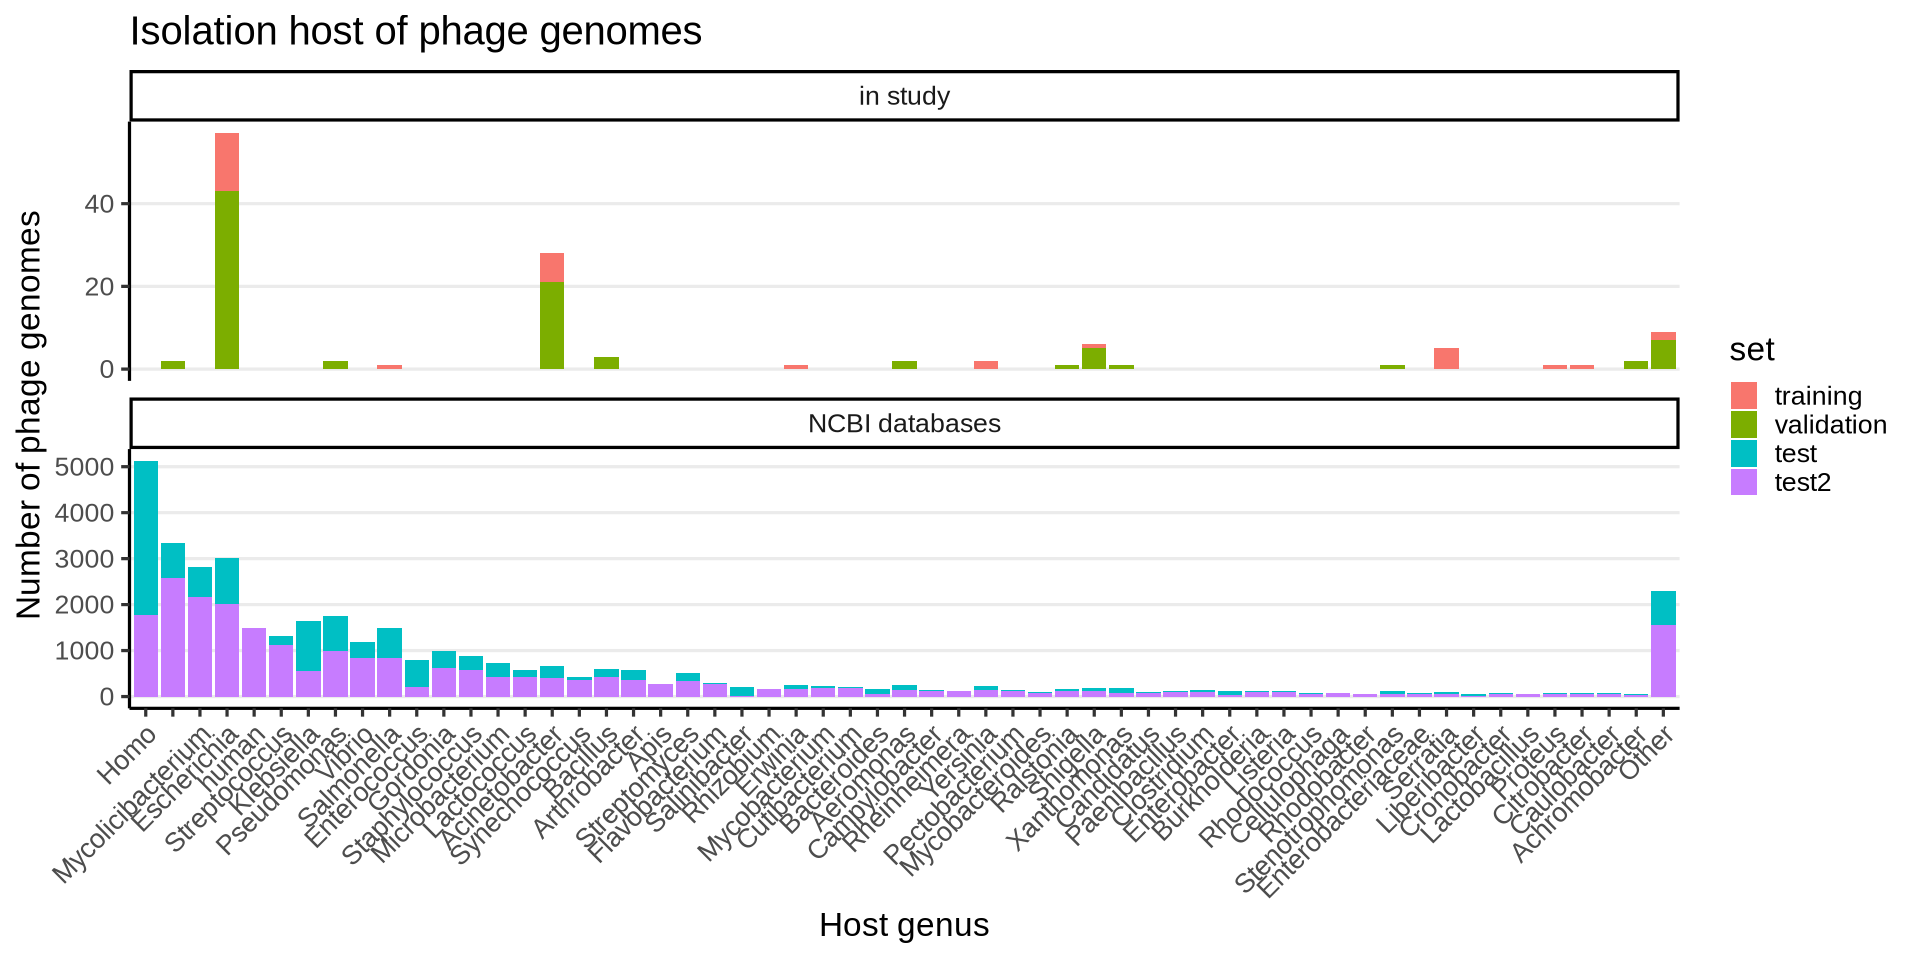

In [11]:
# Representativeness of data sets
options(repr.plot.width=16, repr.plot.height=8)

## Select
df <- report
df$N <- 1

## Summarize
df <- df %>% group_by(genus) %>% mutate(genus_size = sum(N))
df$genus[df$genus_size < 60] <- 'Other'
df <- df %>% group_by(set, genus, Source.database) %>% summarize(total = sum(N))

## Order
df <- df[order(df$total, decreasing = TRUE), ]
genus_levels <- unique(df$genus)
genus_levels <- genus_levels[-which(genus_levels == 'Other')]
genus_levels <- c(genus_levels, 'Other')
df$genus <- factor(df$genus, genus_levels)
df$set <- factor(df$set, c('training','validation','test','test2'))

## Create facets
df$facet <- NA
df$facet[df$set %in% c('training','validation')] <- 'in study'
df$facet[df$set %in% c('test','test2')] <- 'NCBI databases'

## Plot
ggplot(df, aes(genus, total, fill=set)) +
  geom_col() +
  facet_wrap(~facet, nrow = 2, scales = 'free_y') +
  theme_classic(20) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line()
  ) +
  labs(title='Isolation host of phage genomes', x = 'Host genus', y='Number of phage genomes')

In [12]:
# TODO: Clean host genus

In [13]:
# Annotation

## Fetch data
data <- training$features
length(unique(data$Gene.CDS.Name))

## Look up gene 
data$Gene.CDS.Name[str_detect(data$Gene.CDS.Name, 'ara') & str_detect(data$Gene.CDS.Name, 'transfer')]

# Transfer into new vector
data$annotation <- data$Gene.CDS.Name
data$annotation <- 'Other'

## Step A - dCTP modification
data$annotation[str_detect(data$Gene.CDS.Name, 'dCTP') & str_detect(data$Gene.CDS.Name, 'ase')] <- 'dCTPase'
data$annotation[str_detect(data$Gene.CDS.Name, 'peptidase') & str_detect(data$Gene.CDS.Name, 'U32')] <- 'HMase'
data$annotation[str_detect(data$Gene.CDS.Name, 'dCMP') & str_detect(data$Gene.CDS.Name, 'hydroxy')] <- 'HMase'
data$annotation[str_detect(data$Gene.CDS.Name, 'dNMP kinase')] <- 'dNMP kinase'
data$annotation[str_detect(data$Gene.CDS.Name, 'DNA pol')] <- 'DNA pol'

## Step B - UTP arabinosylation
data$annotation[str_detect(data$Gene.CDS.Name, 'arabinose') & str_detect(data$Gene.CDS.Name, 'isomerase')] <- 'Ara iso'
data$annotation[str_detect(data$Gene.CDS.Name, 'phosphoheptose') & str_detect(data$Gene.CDS.Name, 'isomerase')] <- 'Ara iso'
data$annotation[str_detect(data$Gene.CDS.Name, 'NTP') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'NTP transfer'

## Step C - Glucosylation
data$annotation[str_detect(data$Gene.CDS.Name, 'glucos') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'Glu transfer'

## Step D - Ararbinosylation
data$annotation[str_detect(data$Gene.CDS.Name, 'ara') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'Aat'
# Most Aat genes are not annotated !!!

## Step E - function?
data$annotation[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'synthase')] <- 'Thy syn'
data$annotation[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'kinase')] <- 'Thy kin'

unique(data$annotation)
length(unique(data$annotation))

[1] 1086

[1] "putative hmC-arabinosyltransferase" "putative hmC-arabinosyltransferase"

[1] "Other"        "dCTPase"      "Glu transfer" "HMase"        "DNA pol"     
 [6] "dNMP kinase"  "Thy syn"      "Ara iso"      "Thy kin"      "Aat"         
[11] "NTP transfer"

[1] 11

In [14]:
# Add colors
cols <- list()

cols$annotation <- c(
    'Other' = 'grey90',
    'dCTPase' = 'palegreen',
    'HMase' = 'plum',
    'dNMP kinase' = 'seagreen',
    'DNA pol' = 'darkolivegreen',
    'Ara iso' = 'navy',
    'NTP transfer' = 'cyan3',
    'Glu transfer' = 'darkorange',
    'Aat' = 'indianred',
    'Thy syn' = 'purple',
    'Thy kin' = 'hotpink'
)
data$annotation <- factor(data$annotation, names(cols$annotation))

In [15]:
# Modify data

## Modification group
index <- match(data$Accession, tables$phages$accession)
data$aat <- tables$phages$group_aat[index]
data$modification <- tables$phages$group_modification[index]

## Genome size
data <- data %>% group_by(Accession) %>% mutate(
    genomeSize = max(Gene.CDS.Nucleotide.FASTA.Range.Stop, na.rm=TRUE) - min(Gene.CDS.Nucleotide.FASTA.Range.Start, na.rm=TRUE)
)

## Add virus name
index <- match(data$Accession, report$Accession)
data$Name <- report$Virus.Name[index]

Warning message:
“Removed 223 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_text()`).”


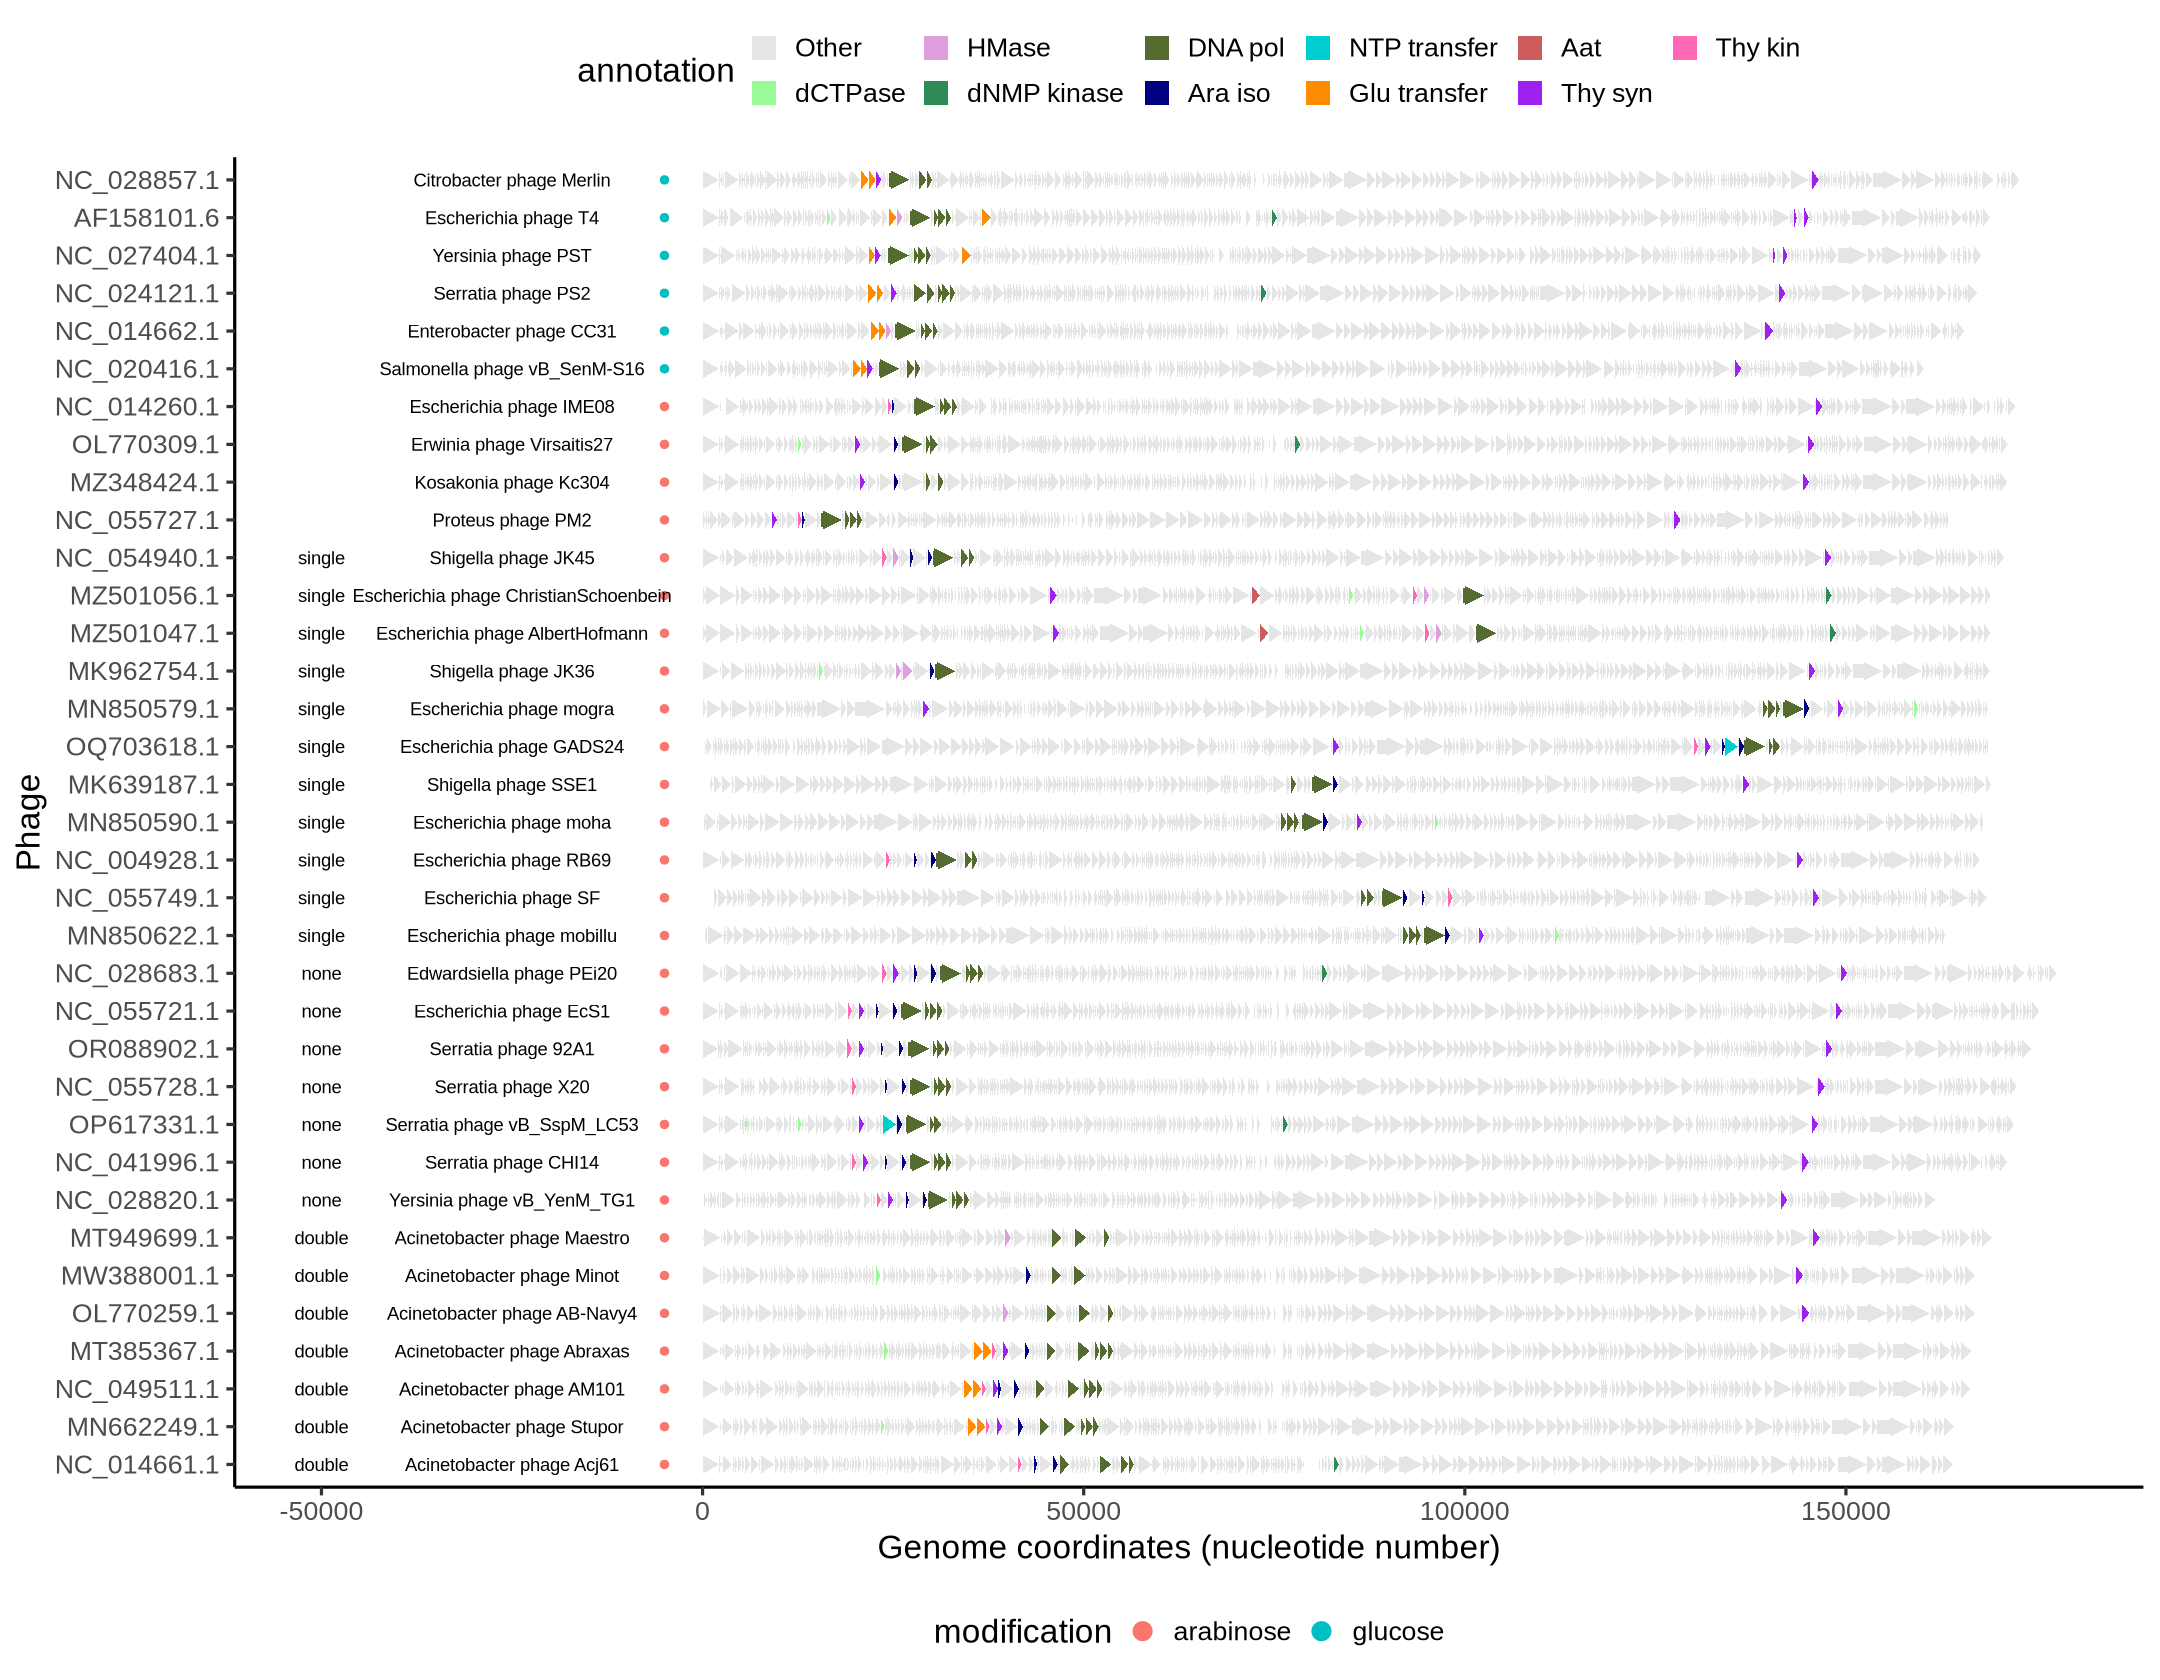

In [16]:
# Visualize genomes
options(repr.plot.width=18, repr.plot.height=14)

## Fetch data
df <- data

## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$aat, df$genomeSize), ]
df$Accession <- factor(df$Accession, unique(df$Accession))

# Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Accession, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    geom_point(data=ann, aes(x=-5000, y=Accession, col=modification), size=2) +
    geom_text(data=ann, aes(x=-50000, y=Accession, label=aat)) +
    geom_text(data=ann, aes(x=-25000, y=Accession, label=Name)) +
    theme_classic(20) +
    guides(fill = guide_legend(position = 'top', nrow=2), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates (nucleotide number)", y = "Phage")

[1] "Aat"          "Ara iso"      "dCTPase"      "HMase"        "dNMP kinase" 
[6] "NTP transfer" "Thy kin"      "Thy syn"      "Glu transfer"

[1] TRUE

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


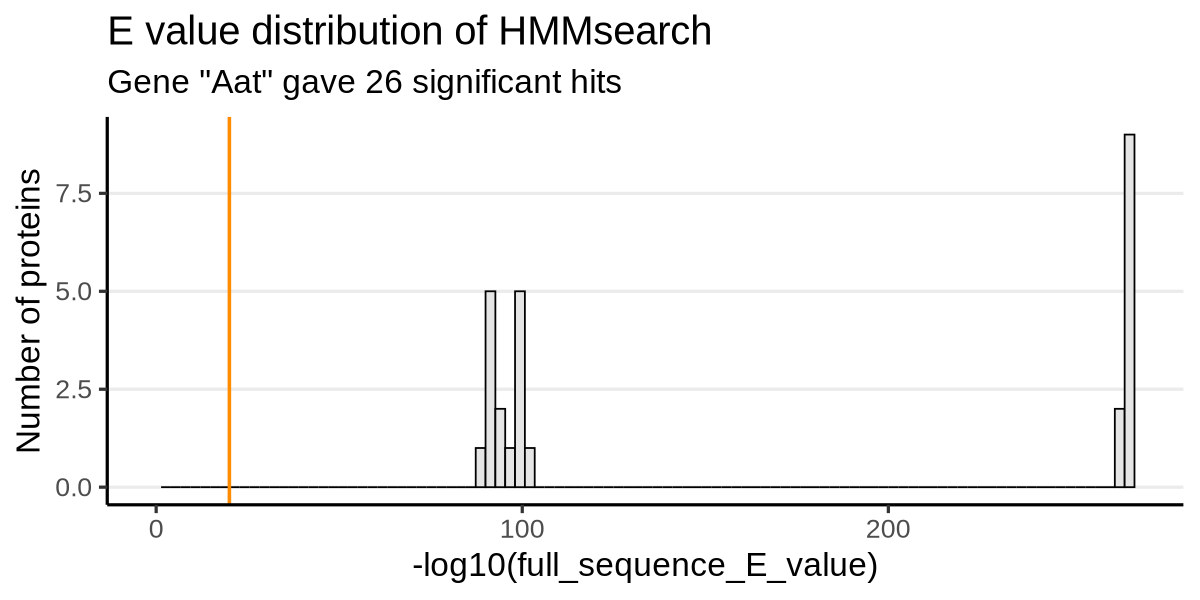

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


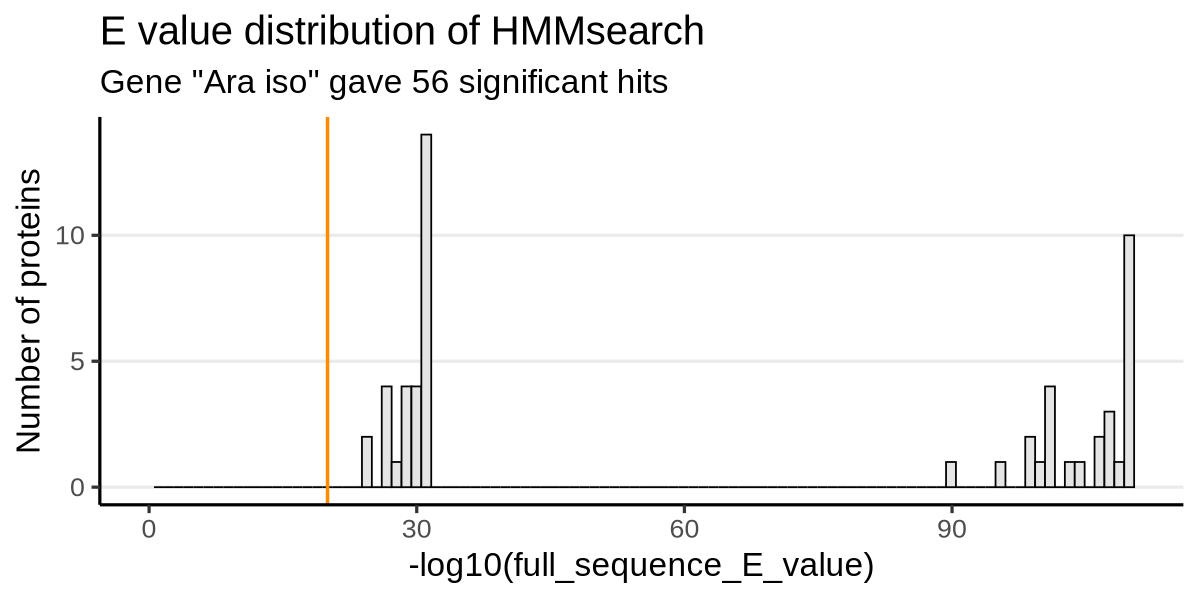

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 90”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 

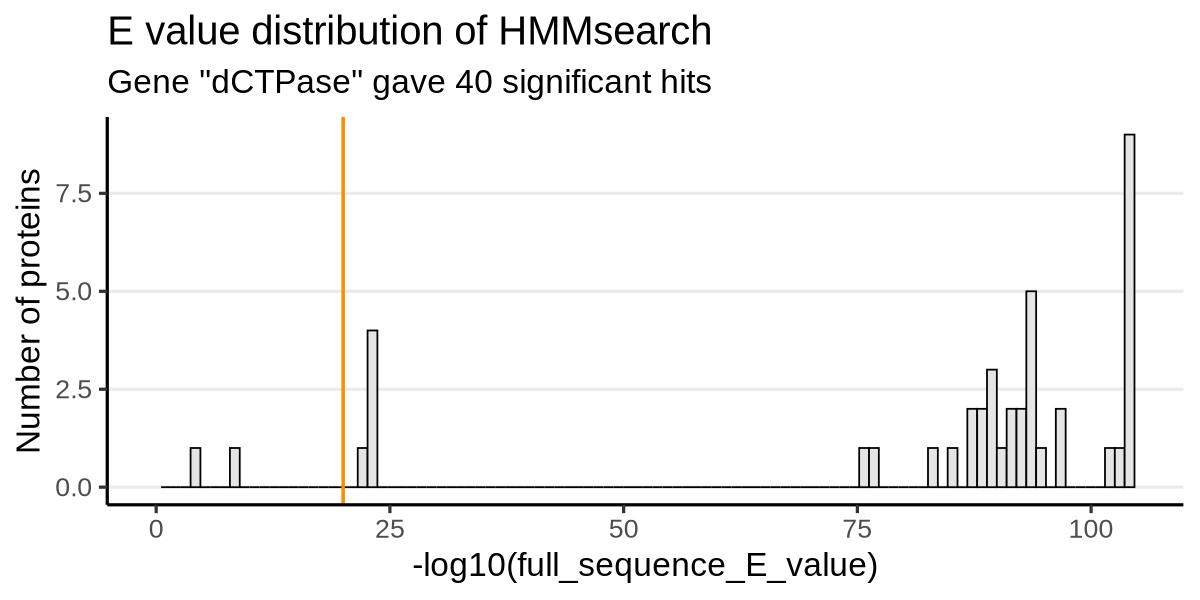

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


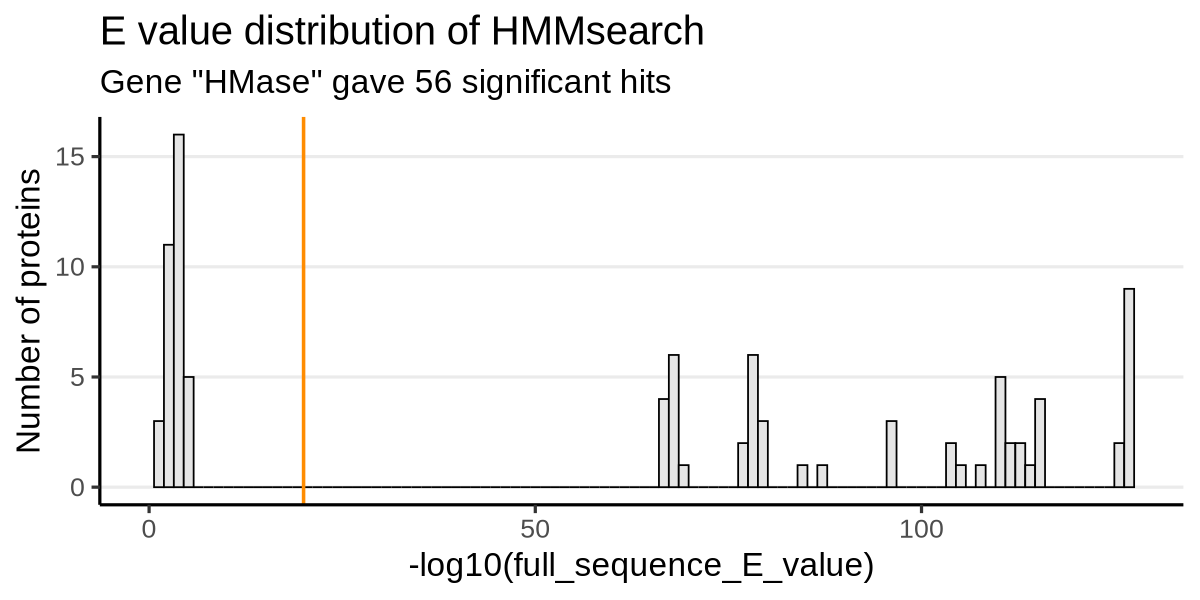

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 16 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


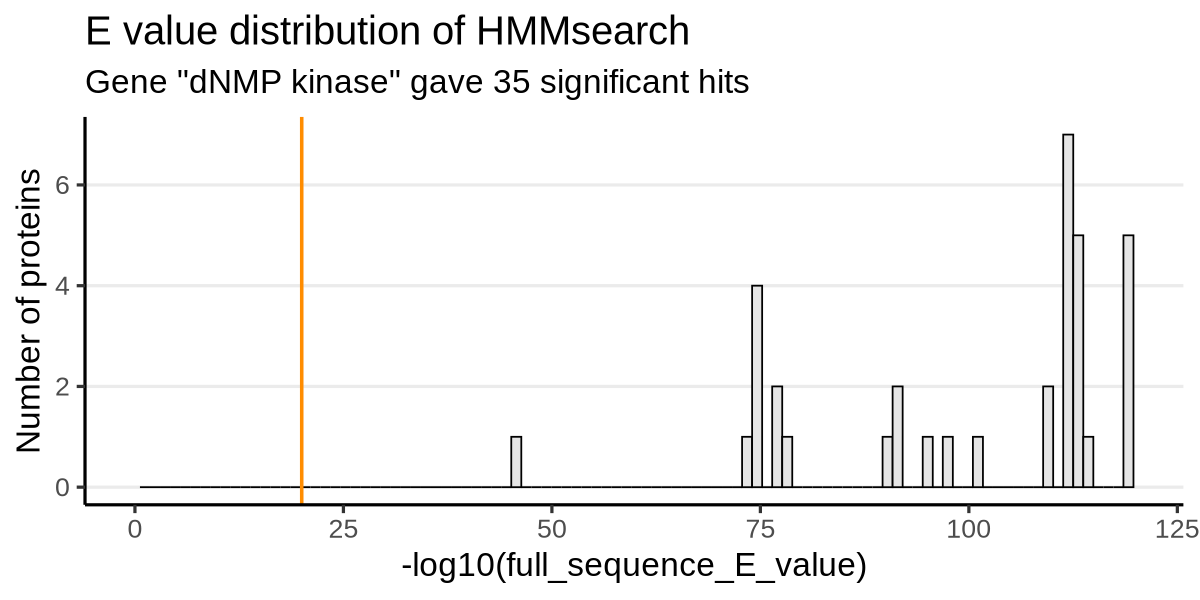

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


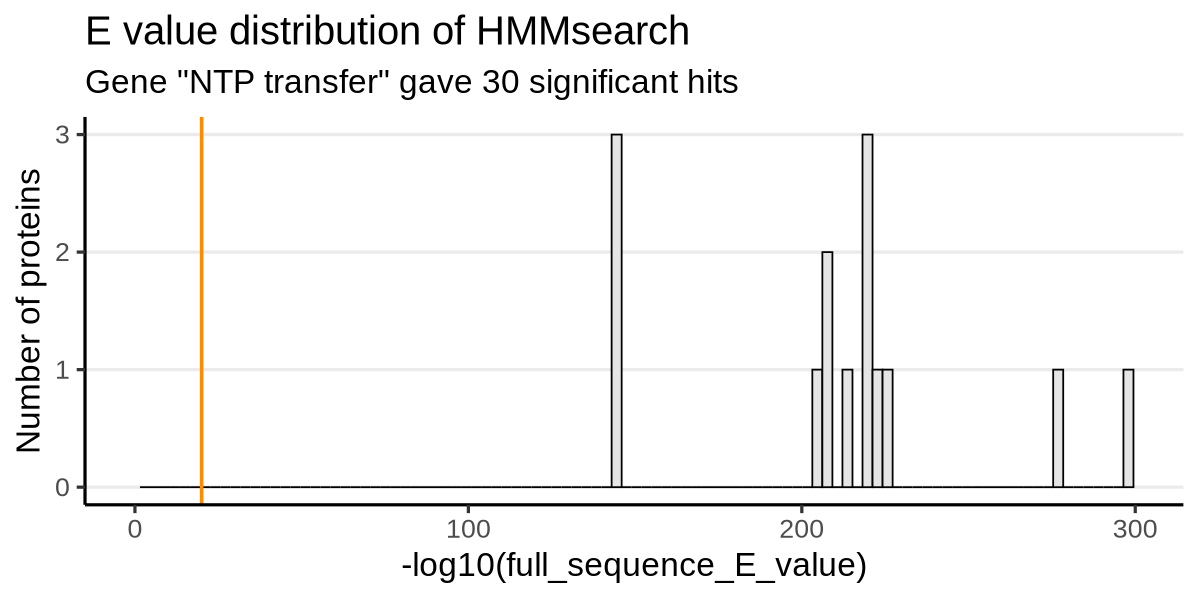

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


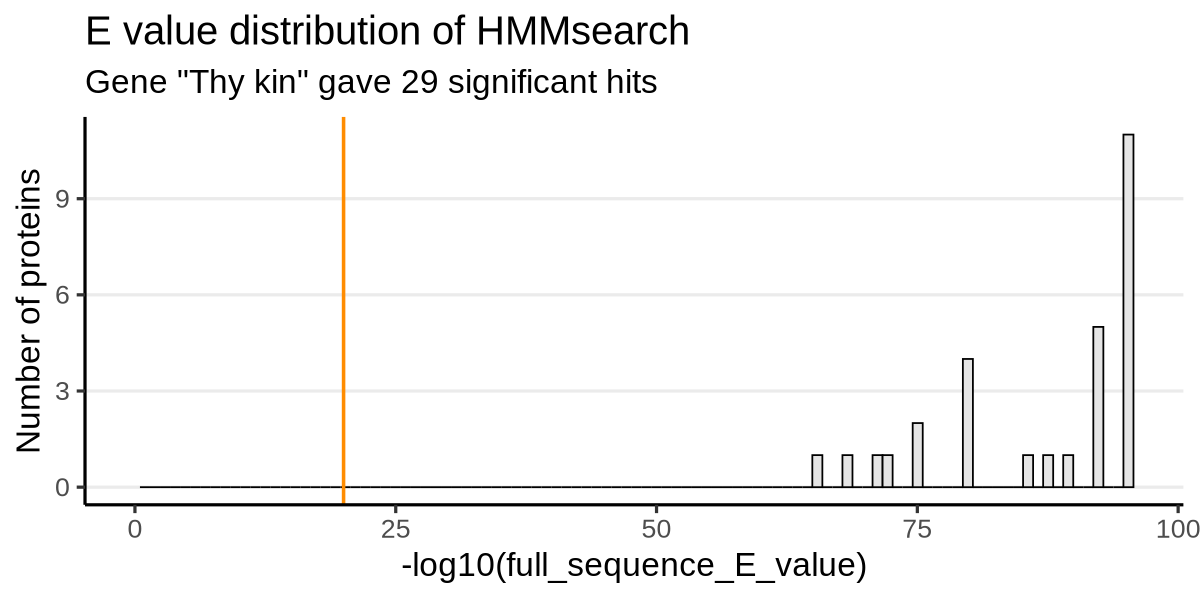

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


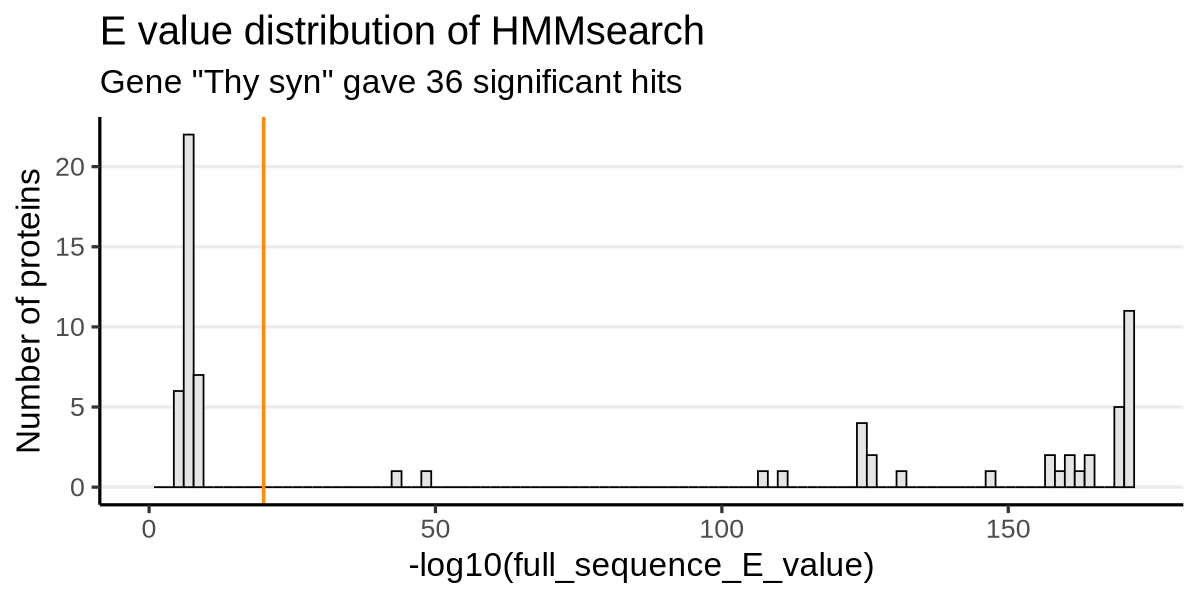

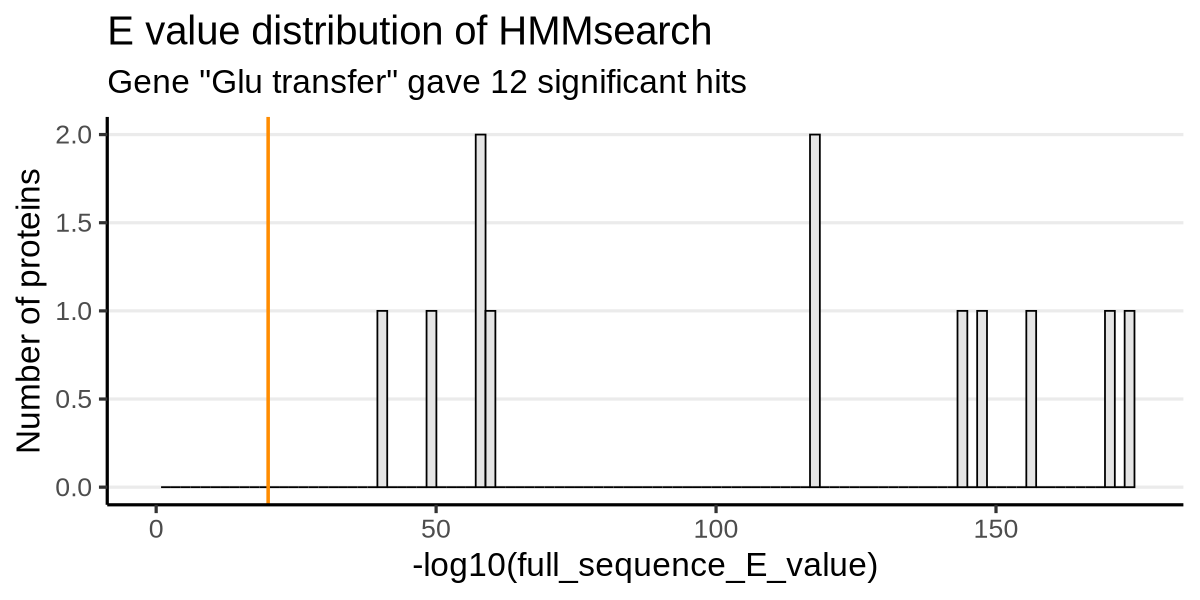

In [17]:
# Refine annotations
options(repr.plot.width=10, repr.plot.height=5)

genes <- c('Aat','Ara iso','dCTPase','HMase','dNMP kinase','NTP transfer','Thy kin','Thy syn','Glu transfer')
genes

## Check spelling
all(genes %in% levels(data$annotation))

## Iterate annotation over genes
for (gene in genes) {
    x <- annotate_gene_by_hmm_profile(data, gene = gene, search_db = fs$training$protein, dir = out_path)$Sequence
    data$annotation[which(data$Gene.CDS.Protein.FASTA.Sequence.ID %in% x)] <- gene
}

Warning message:
“Removed 223 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_text()`).”


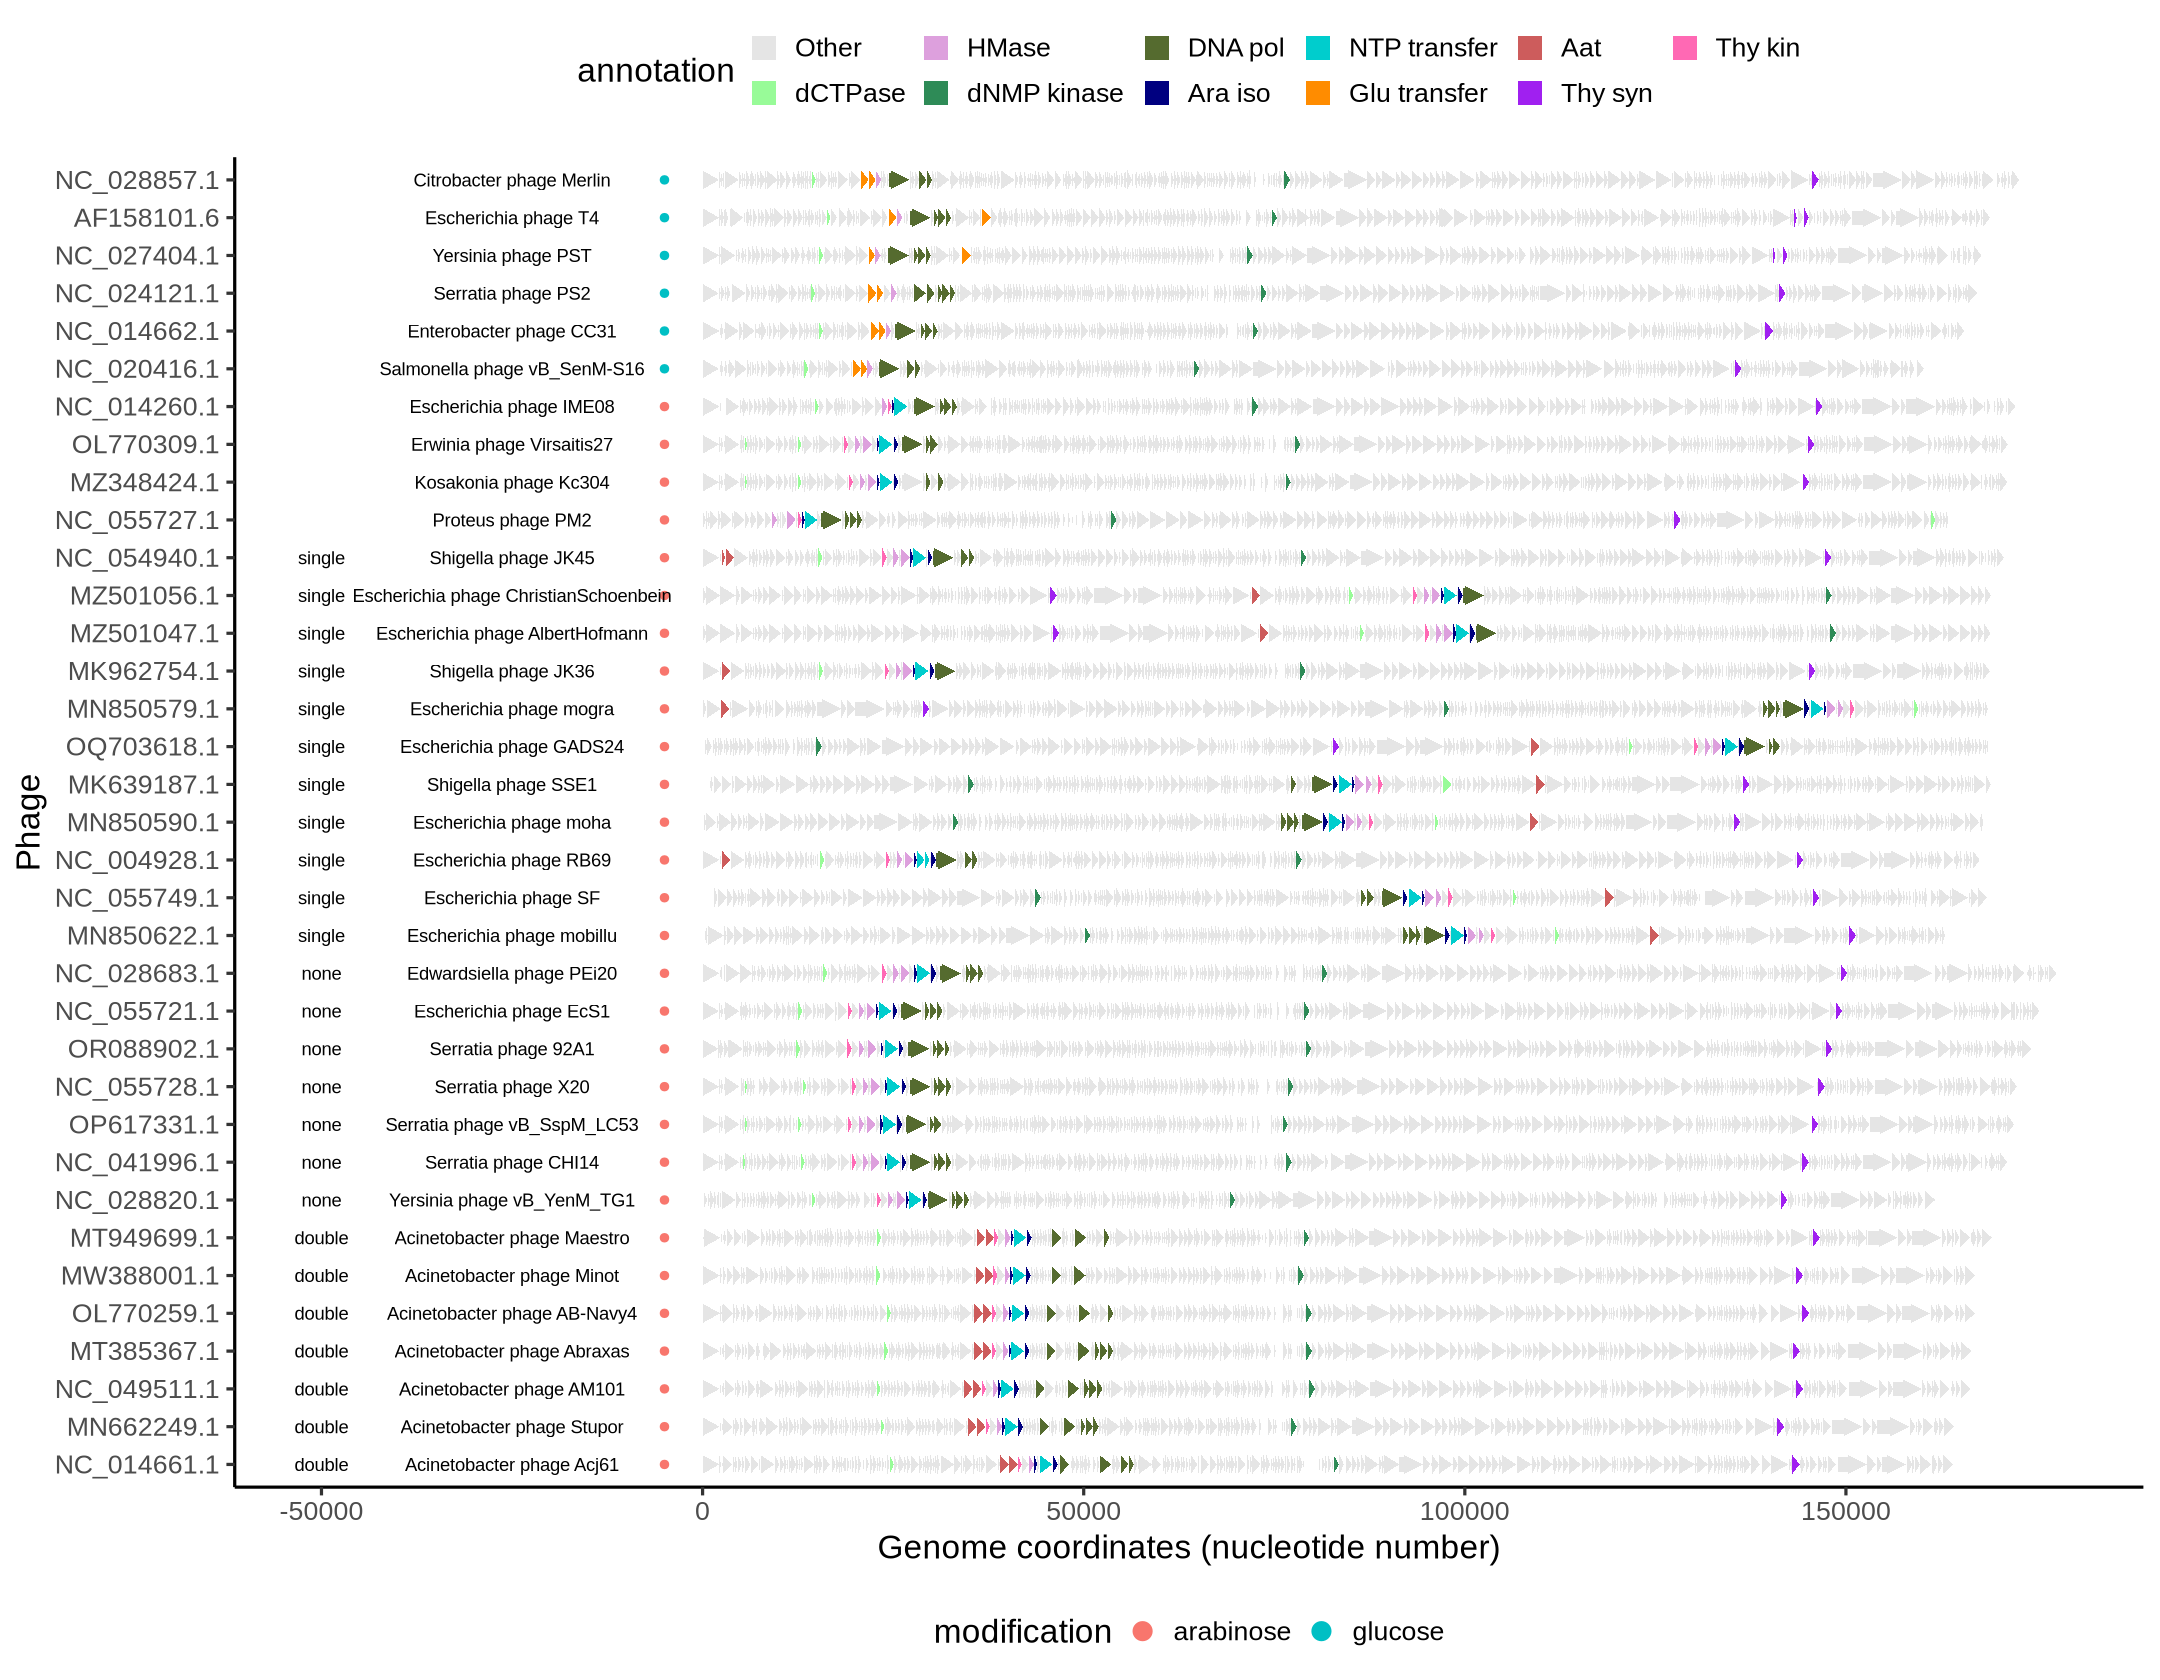

In [18]:
# Visualize genomes
options(repr.plot.width=18, repr.plot.height=14)

## Fetch data
df <- data

## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$aat, df$genomeSize), ]
df$Accession <- factor(df$Accession, unique(df$Accession))

## Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Accession, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    geom_point(data=ann, aes(x=-5000, y=Accession, col=modification), size=2) +
    geom_text(data=ann, aes(x=-50000, y=Accession, label=aat)) +
    geom_text(data=ann, aes(x=-25000, y=Accession, label=Name)) +
    theme_classic(20) +
    guides(fill = guide_legend(position = 'top', nrow=2), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates (nucleotide number)", y = "Phage")

Warning message:
“Removed 5902 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_text()`).”


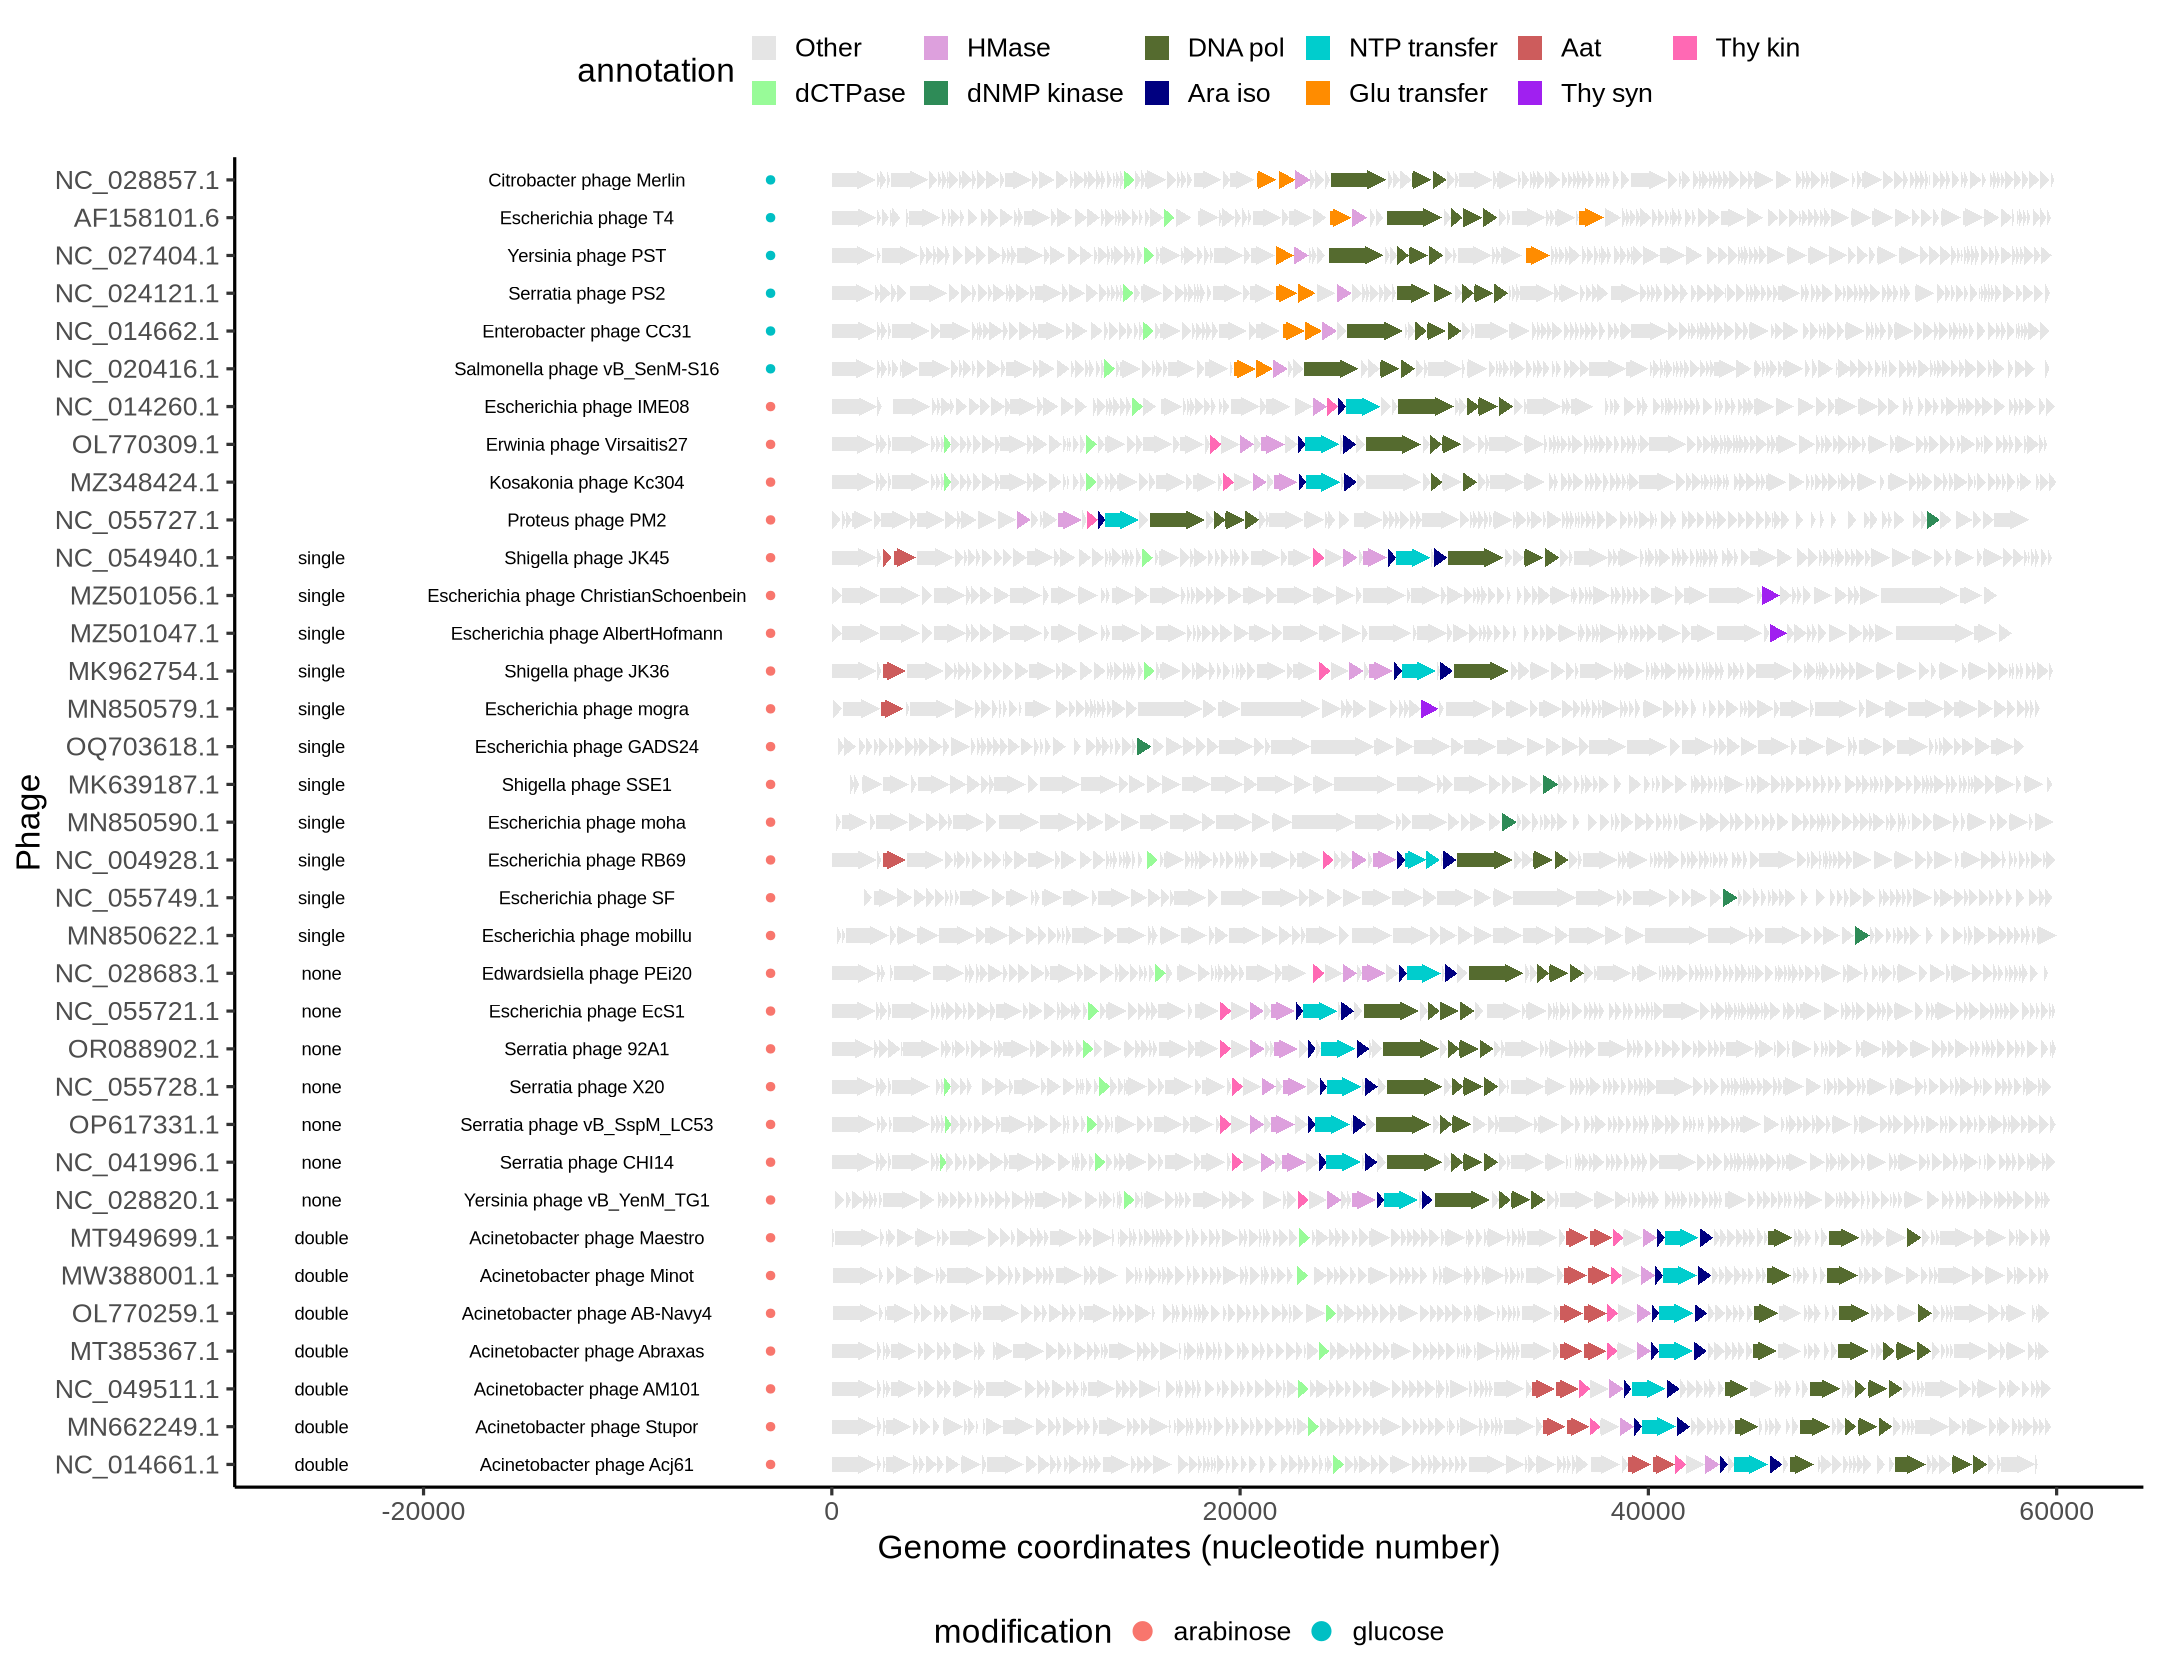

In [22]:
# Crop
options(repr.plot.width=18, repr.plot.height=14)

## Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Accession, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    geom_point(data=ann, aes(x=-3000, y=Accession, col=modification), size=2) +
    geom_text(data=ann, aes(x=-25000, y=Accession, label=aat)) +
    geom_text(data=ann, aes(x=-12000, y=Accession, label=Name)) +
    theme_classic(20) +
    guides(fill = guide_legend(position = 'top', nrow=2), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates (nucleotide number)", y = "Phage") +
    scale_x_continuous(limits = c(NA, 60000))

`summarise()` has grouped output by 'Accession'. You can override using the
`.groups` argument.


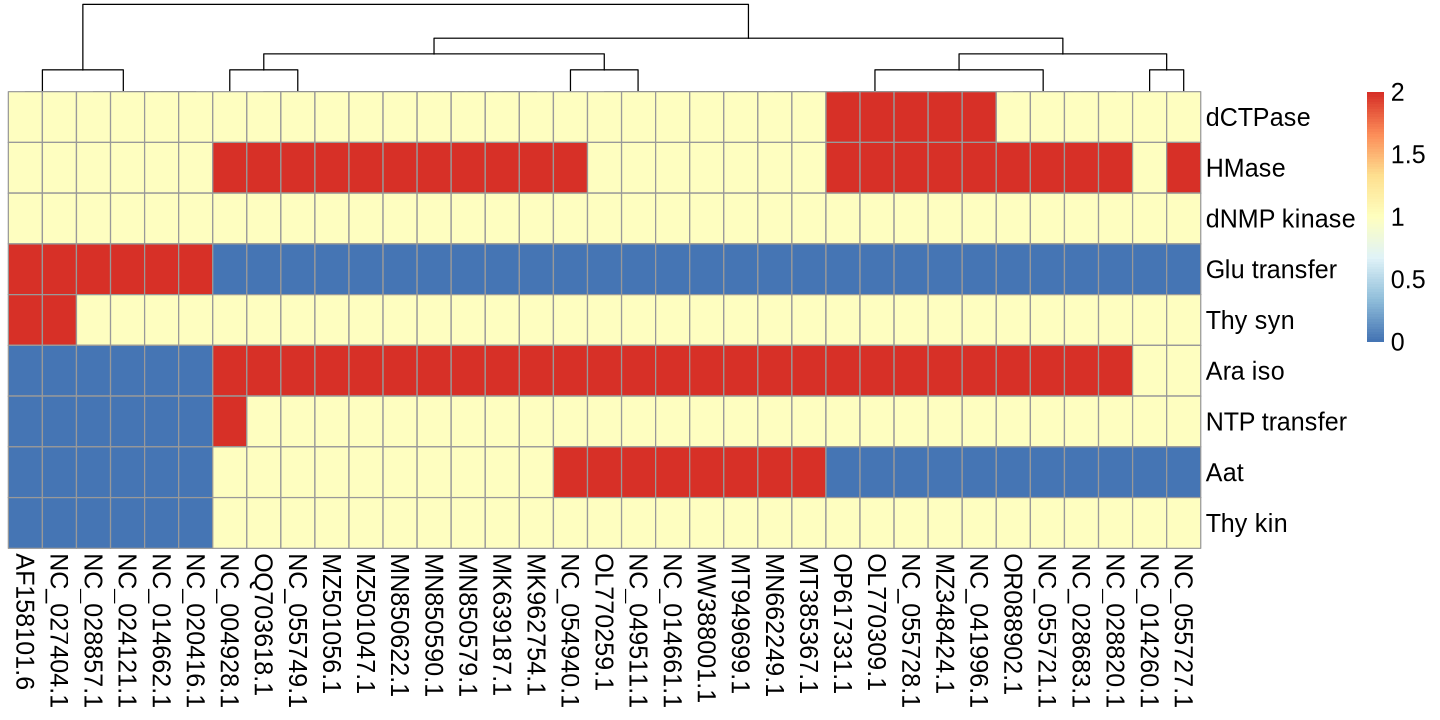

In [26]:
# Feature quantification
options(repr.plot.width=12, repr.plot.height=6)

## Summarize gene counts
df <- data %>% mutate(N=1) %>% group_by(Accession, annotation) %>% summarize(total = sum(N))

## Filter
index <- !df$annotation %in% c('Other','DNA pol')
df <- df[index,]

## Reshape
mat <- df %>% pivot_wider(names_from = Accession, values_from = total, values_fill = 0) %>% as.data.frame()
rownames(mat) <- mat$annotation
mat <- mat[, -1] %>% as.matrix()

## Plot
p1 <- pheatmap::pheatmap(mat, cluster_rows = FALSE, fontsize = 15)


FALSE  TRUE 
    6    29 

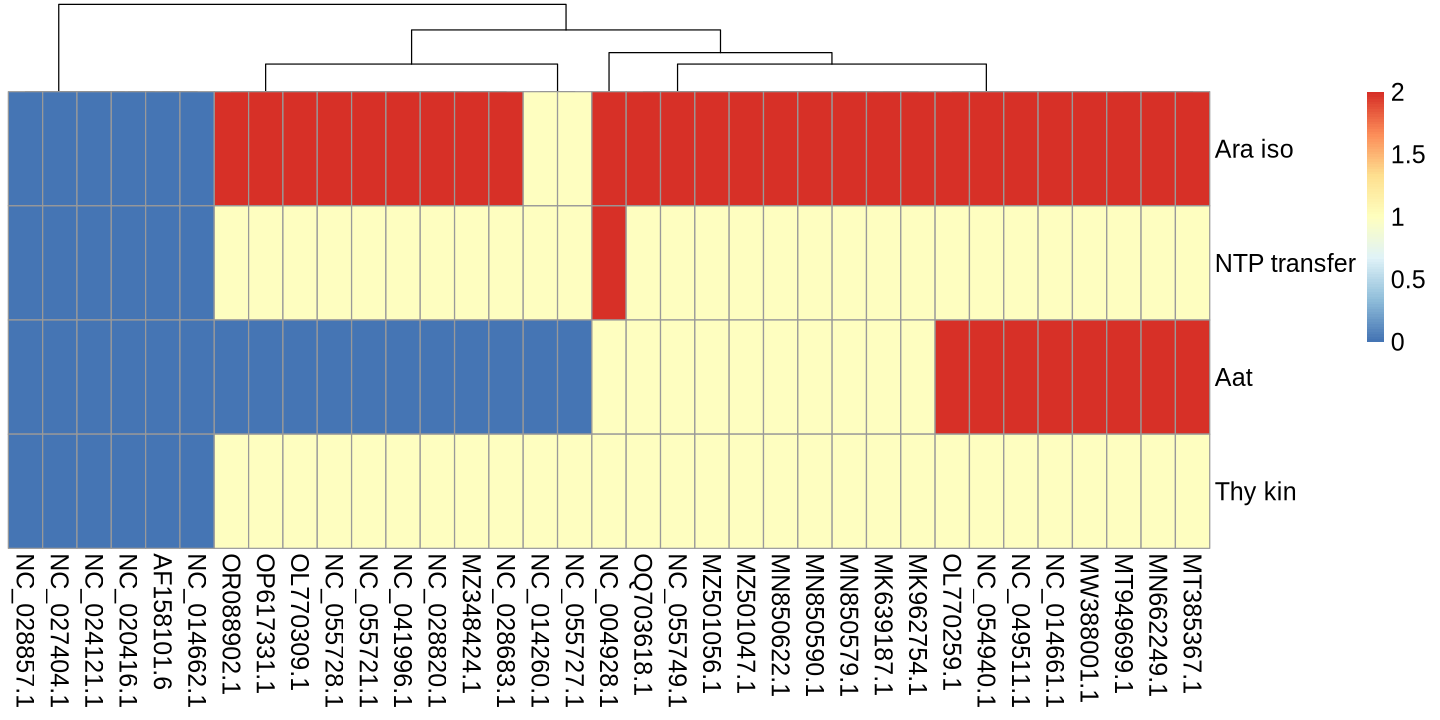

In [27]:
## Subset to arabinosylation genes
index <- rownames(mat) %in% c('Ara iso','NTP transfer','Aat','Thy kin')
mat <- mat[index, ]

## Plot
p2 <- pheatmap::pheatmap(mat, cluster_rows = FALSE, fontsize = 15)

## Quantify
table(colSums(mat) >= 3)

[1] "Aat"          "Ara iso"      "dCTPase"      "HMase"        "dNMP kinase" 
[6] "NTP transfer" "Thy kin"      "Thy syn"      "Glu transfer"

[1] TRUE

validation 


Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


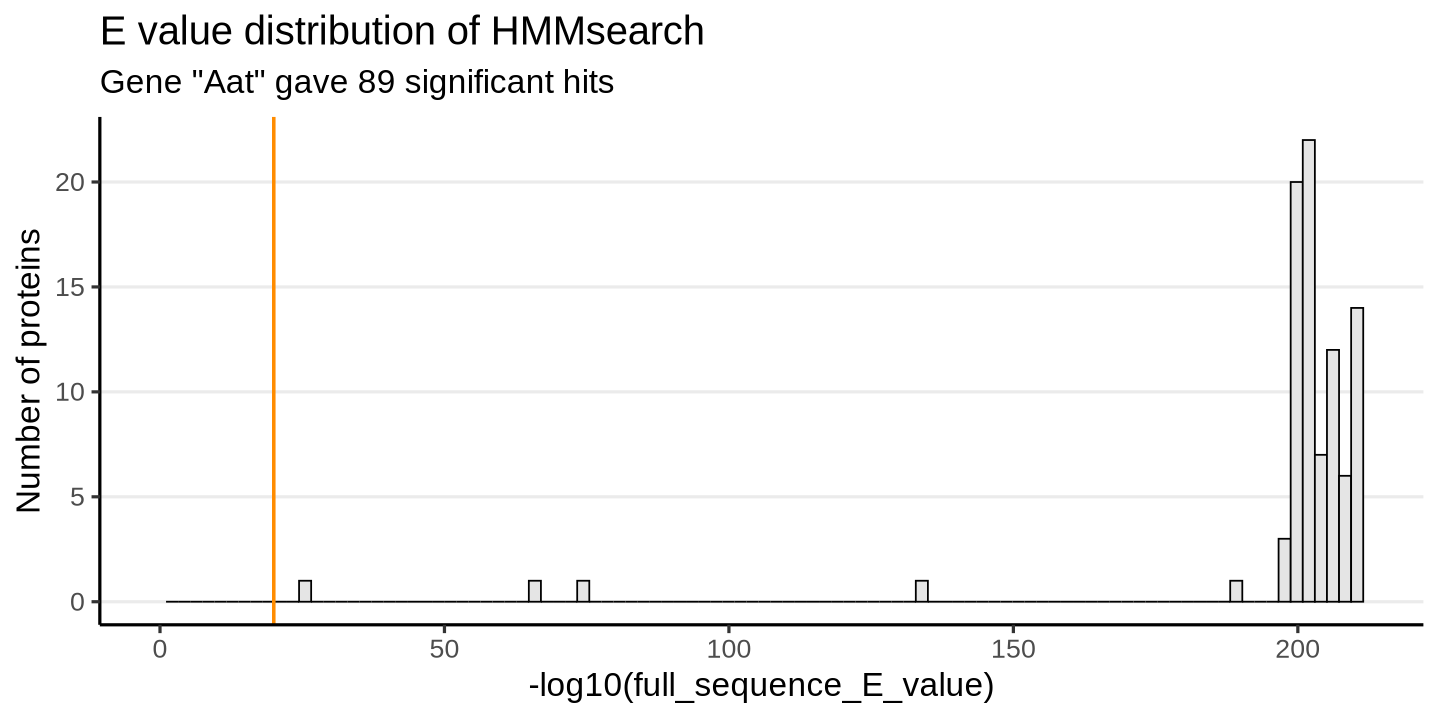

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


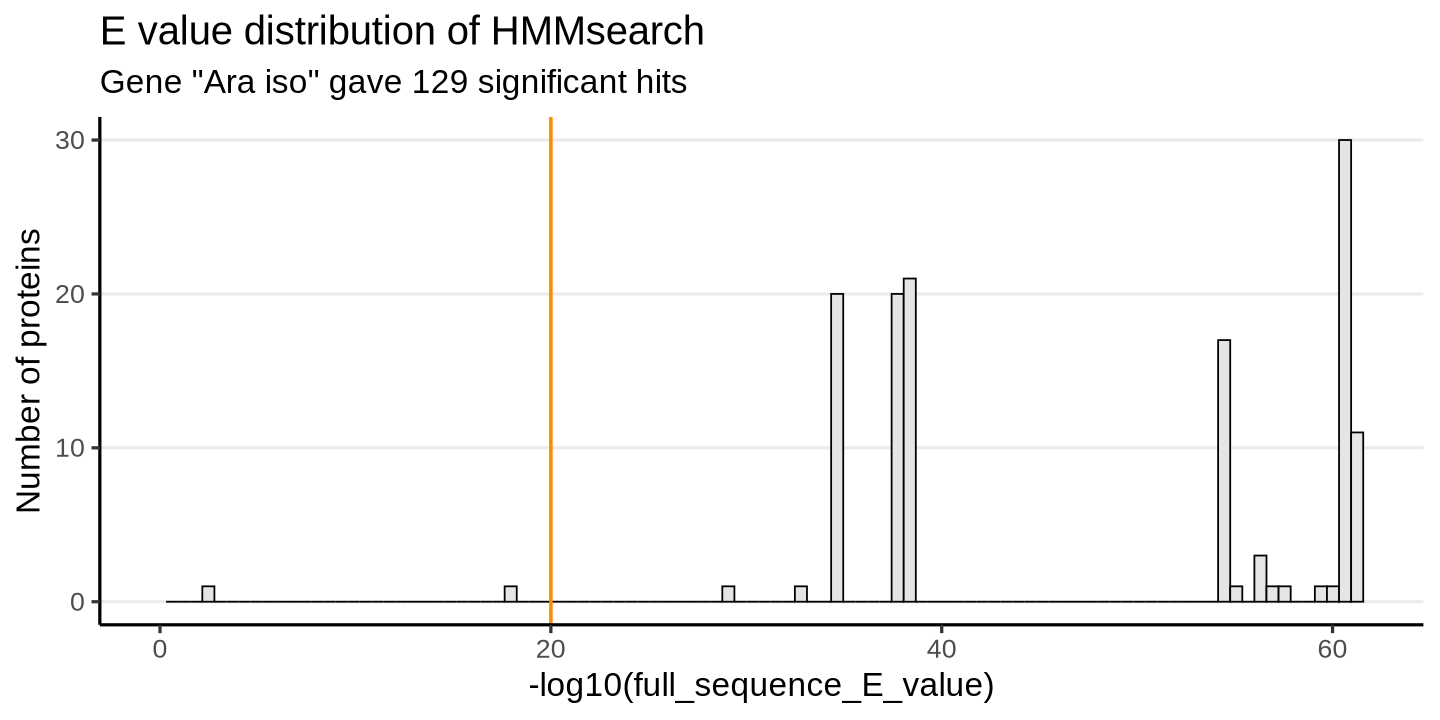

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


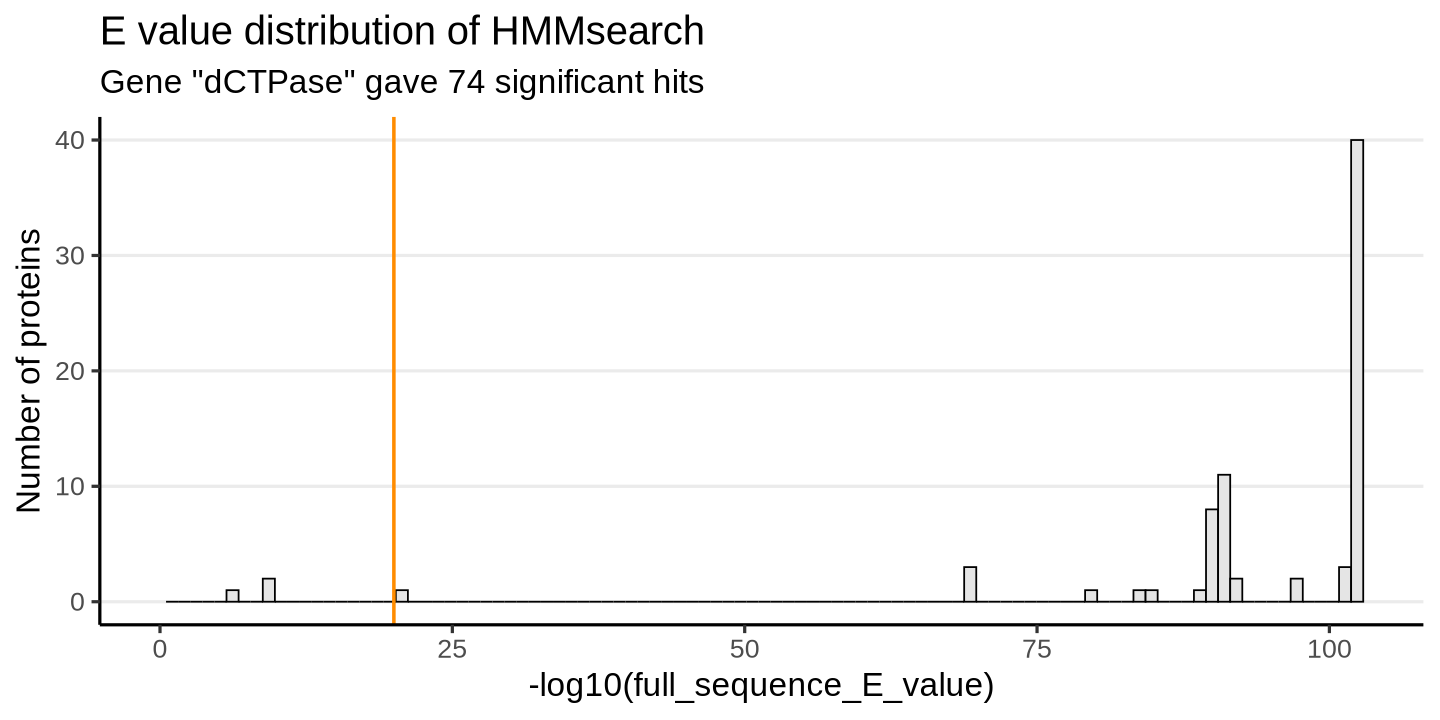

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 75”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 

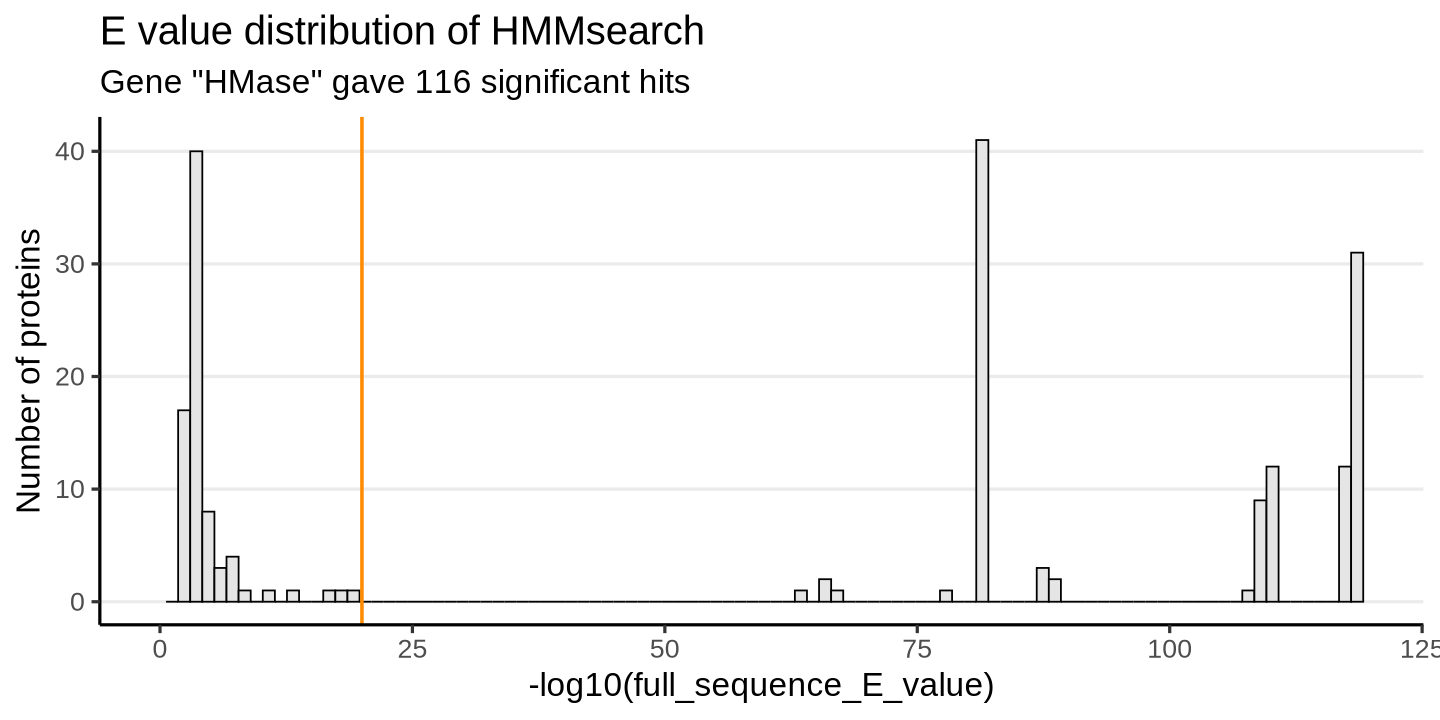

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 41 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


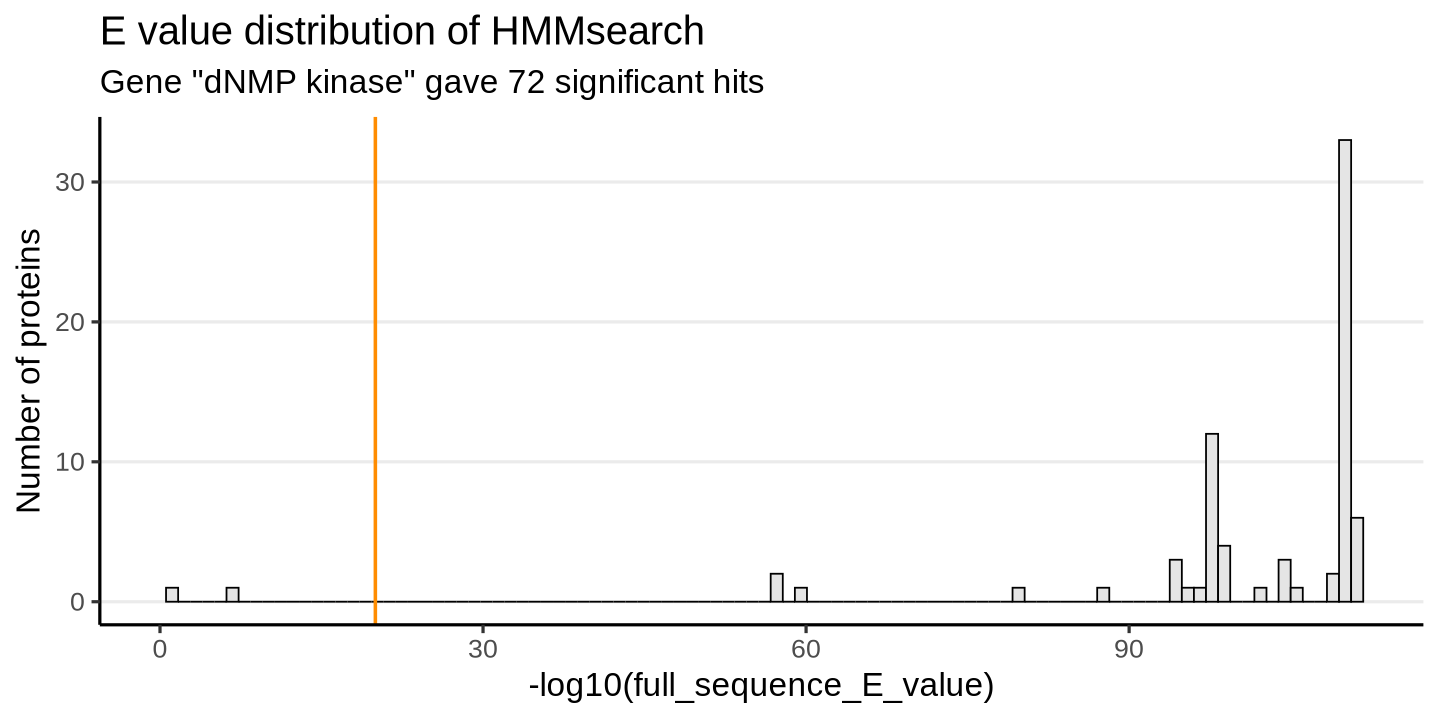

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


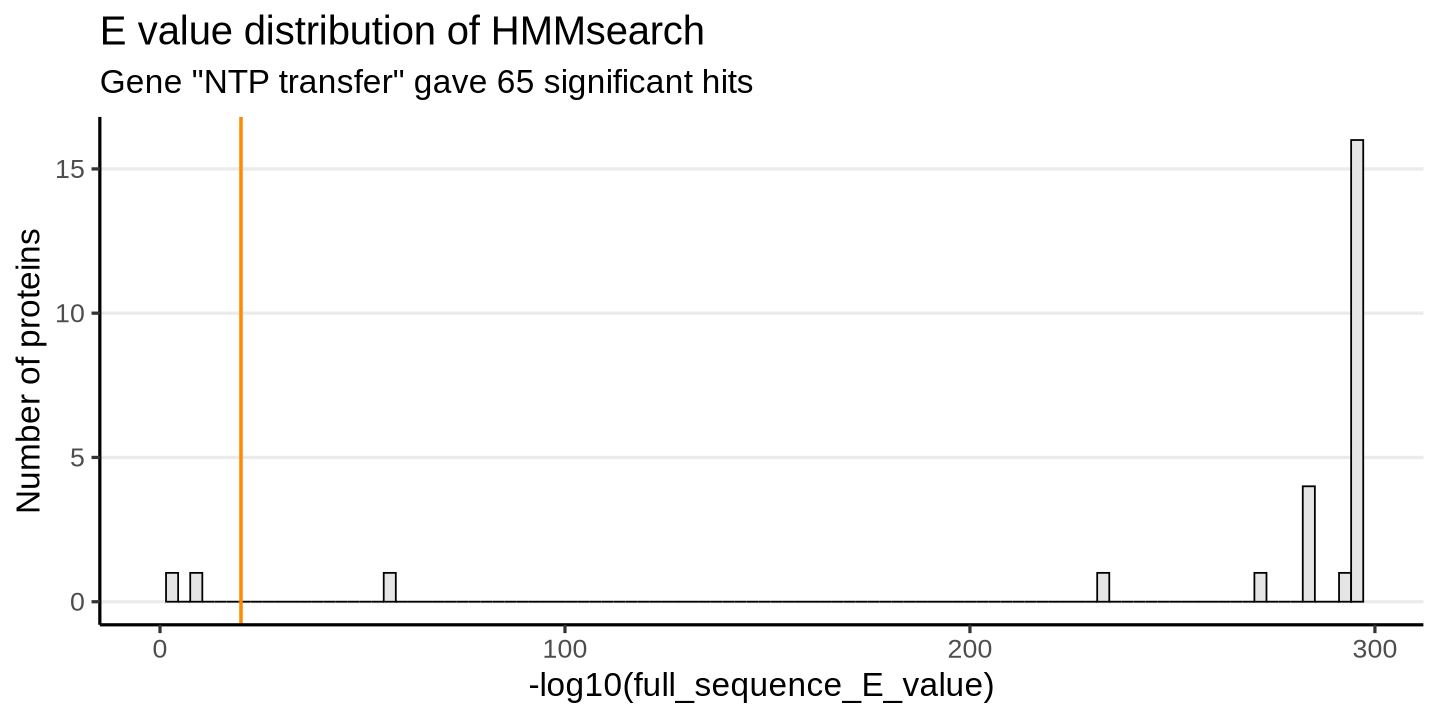

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


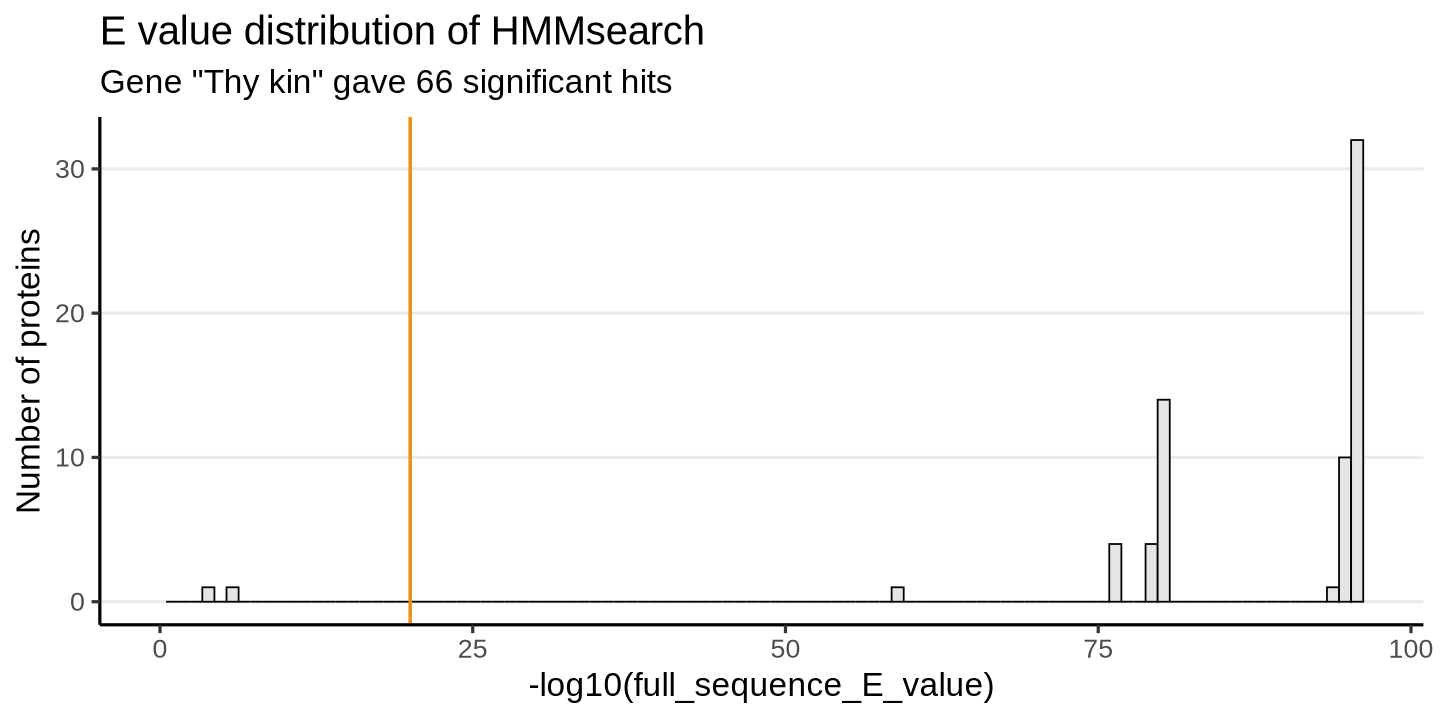

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


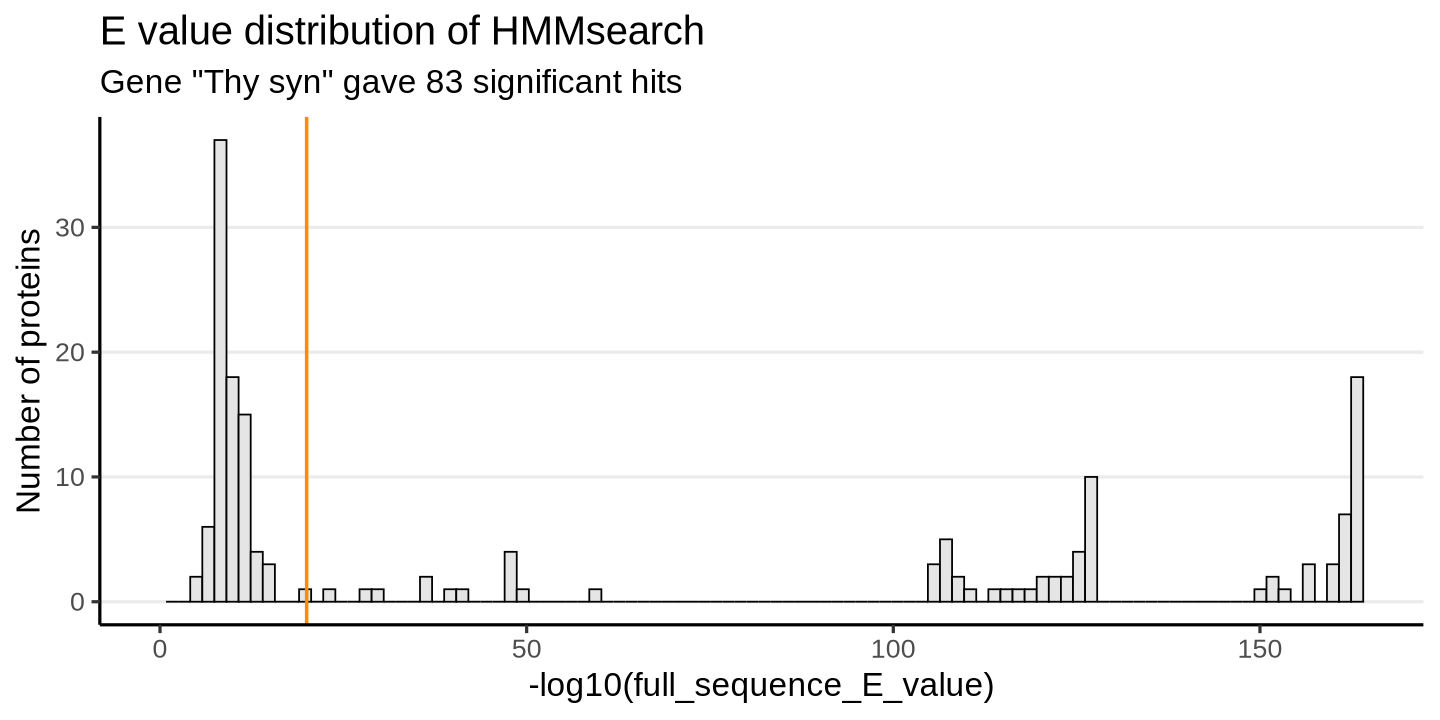

test 


Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 109”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 89 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed

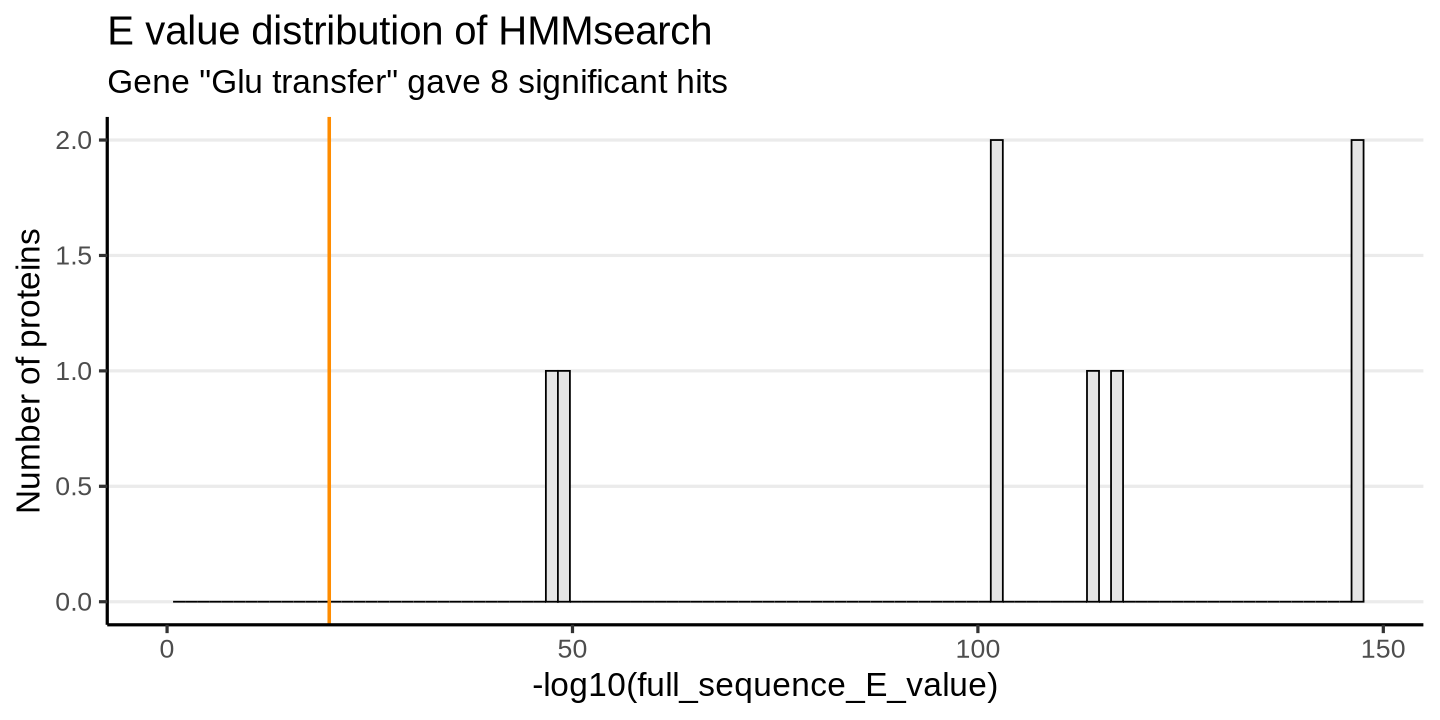

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 334”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 24 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed

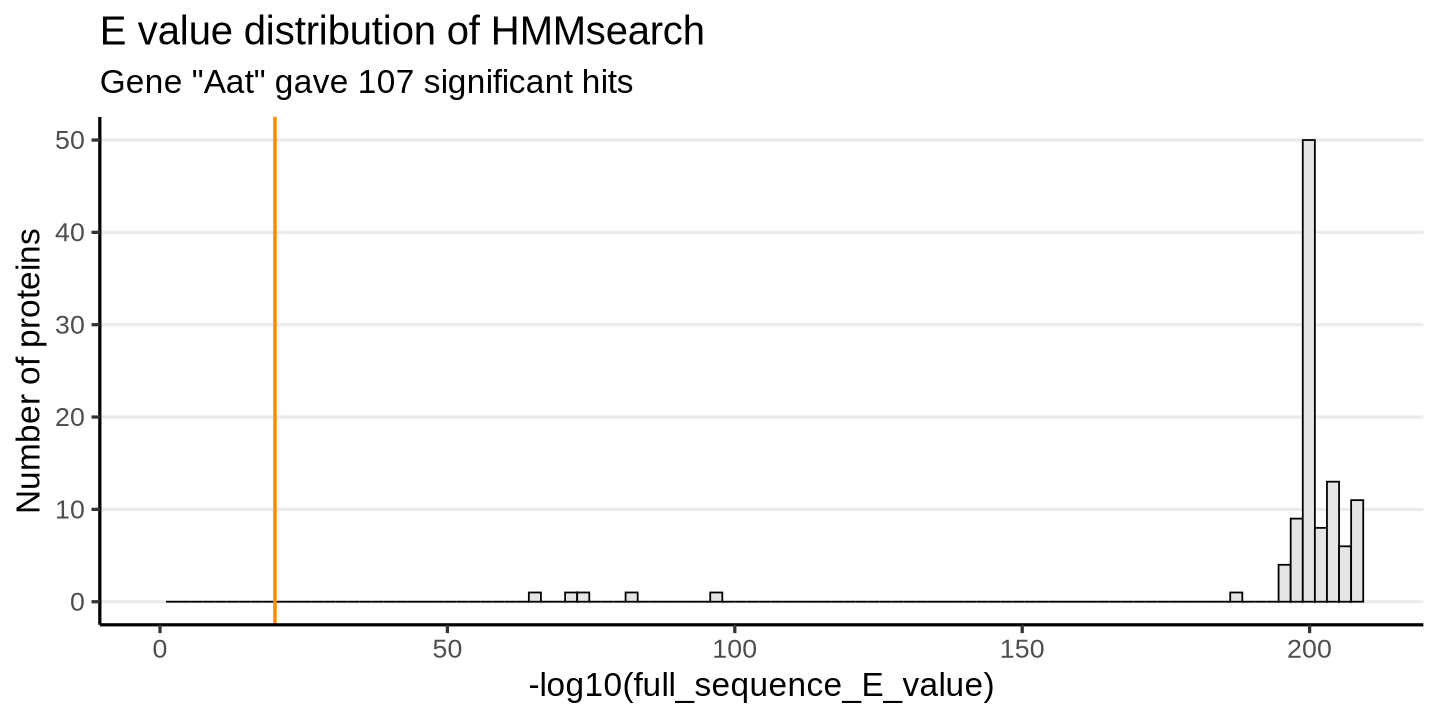

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 1257”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 215 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Remov

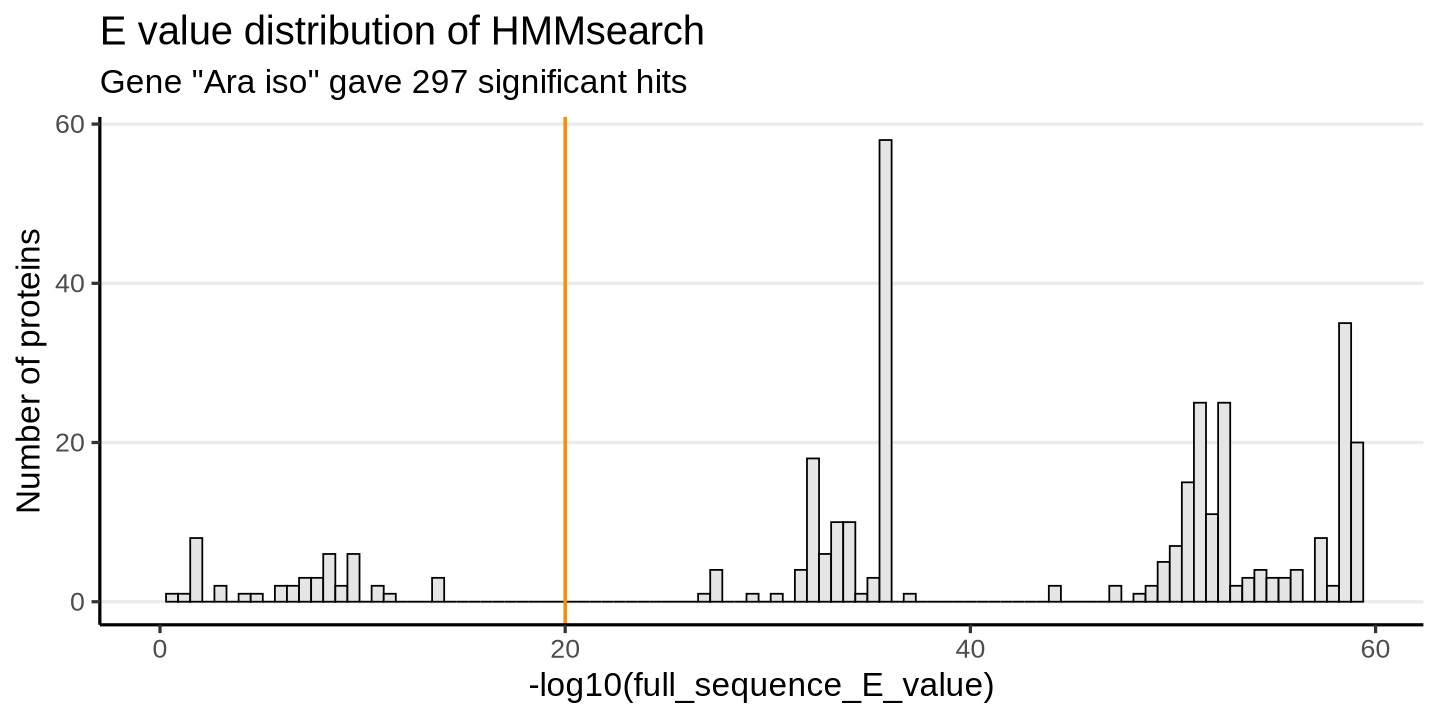

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 3147”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 349 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Remov

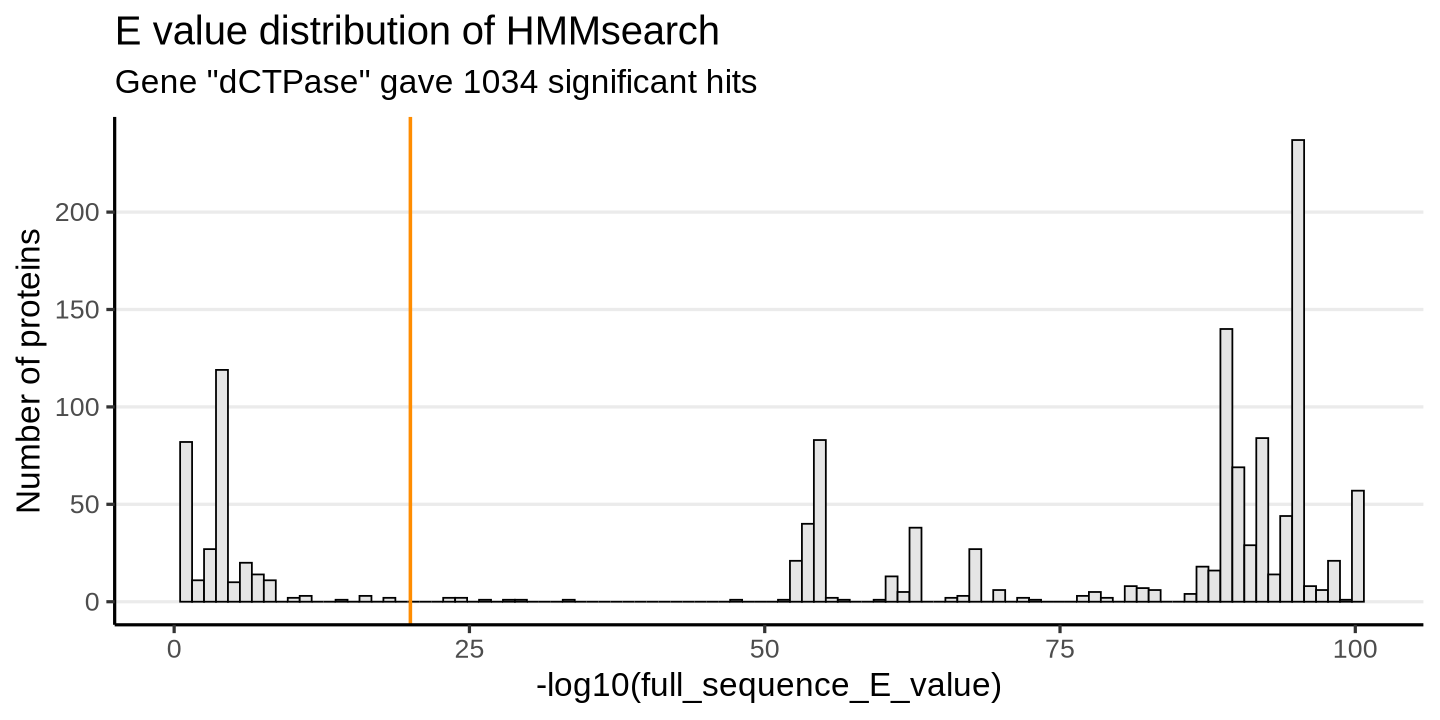

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 3720”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 313 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Remov

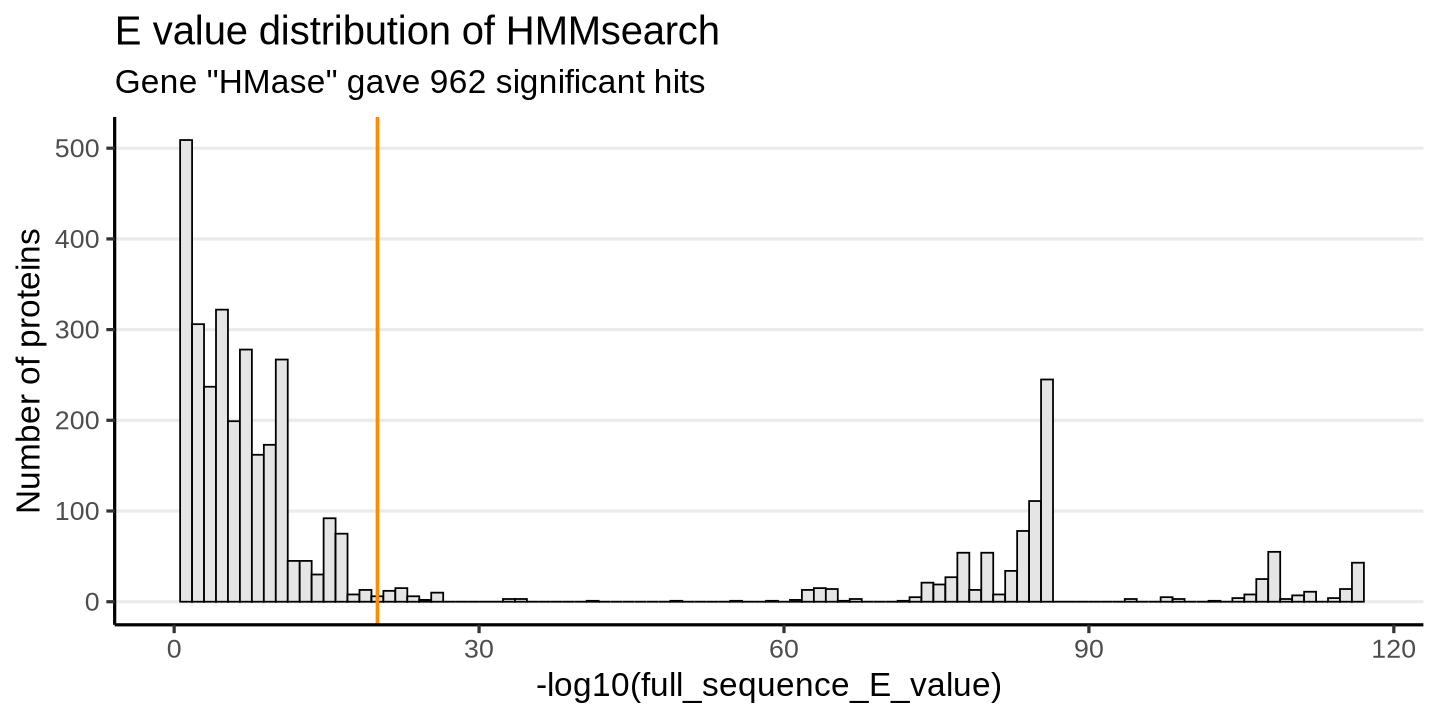

Warning message in dir.create(out_ann):
“'analysis/2025-01-13/annotation' already exists”


In [ ]:
# Annotate genes across genome collections

genes <- c('Aat','Ara iso','dCTPase','HMase','dNMP kinase','NTP transfer','Thy kin','Thy syn','Glu transfer')
genes

## Check spelling
all(genes %in% levels(data$annotation))

## Iterate annotation over genes
result <- list(
    'validation' = list(),
    'test' = list(),
    'test2' = list()    
)
for (i in names(result)) {
    cat(i,'\n')
    for (j in genes) {
        result[[i]][[j]] <- annotate_gene_by_hmm_profile(data, gene = j, search_db = fs[[i]]$protein, dir = out_path)$Sequence
    }
}

## View
str(result, max.level = 2)

In [ ]:
## Combine features across collections

## Re-format result
rdf <- data.frame('collection'=character(), 'gene'=character(), 'seq_id'=character())
for (i in names(result)) {
    for (j in names(result[[i]])) {
        rdf <- rbind(rdf, data.frame('collection'=i, 'gene'=j, 'seq_id'=result[[i]][[j]]))
    }
}

## View
dim(rdf)
head(rdf,3)

## Add duplicates to result
rdf$duplicated <- duplicated(rdf$seq_id)

## Tabulate
table(rdf$duplicated, rdf$collection)

## Filter
rdf <- rdf[!rdf$duplicated, ]

### Add collection to gtf
validation$features$collection <- 'validation'
test$features$collection <- 'test'
test2$features$collection <- 'test2'

### Select columns
fcols <- intersect(names(validation$features), names(test$features))
fcols <- intersect(fcols, names(test2$features))

### Combine data.frames
features <- rbind(
    validation$features[, fcols],
    test$features[, fcols],
    test2$features[, fcols]
)

## Add gene annotations
features$annotation <- 'Other'
index <- match(rdf$seq_id, features$Gene.CDS.Protein.FASTA.Sequence.ID)
features$annotation[index] <- rdf$gene

## Summarize
table(features$annotation)

In [ ]:
# Feature quantification
options(repr.plot.width=12, repr.plot.height=6)

## Summarize gene counts
df <- features %>% mutate(N=1) %>% group_by(Accession, annotation) %>% summarize(total = sum(N))

## Filter
index <- !df$annotation %in% c('Other','DNA pol')
df <- df[index,]

## Reshape
mat <- df %>% pivot_wider(names_from = Accession, values_from = total, values_fill = 0) %>% as.data.frame()
rownames(mat) <- mat$annotation
mat <- mat[, -1] %>% as.matrix()

## Plot
pheatmap::pheatmap(mat, cluster_rows = FALSE,
                   show_colnames=FALSE,
                   fontsize = 15)

## Subset to arabinosylation genes
index <- rownames(mat) %in% c('Ara iso','NTP transfer','Aat','Thy kin')
mat <- mat[index, ]

## Plot
pheatmap::pheatmap(mat, cluster_rows = FALSE, 
                   show_colnames=FALSE,
                   fontsize = 15)

## Quantify
table(colSums(mat) > 2)

In [92]:
dim(mat)
dim(features)

[1]    4 3323

[1] 5330237      72

Warning message in dir.create(out_ann):
“'analysis/2025-01-09/predict_on_validation' already exists”


character(0)

[1] "# hmmbuild :: profile HMM construction from multiple sequence alignments"                       
 [2] "# HMMER 3.4 (Aug 2023); http://hmmer.org/"                                                      
 [3] "# Copyright (C) 2023 Howard Hughes Medical Institute."                                          
 [4] "# Freely distributed under the BSD open source license."                                        
 [5] "# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -"                      
 [6] "# input alignment file:             analysis/2025-01-09/predict_on_validation/Aat_aligned.fasta"
 [7] "# output HMM file:                  analysis/2025-01-09/predict_on_validation/Aat_profile.hmm"  
 [8] "# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -"                      
 [9] ""                                                                                               
[10] "# idx name                  nseq  alen  mlen eff_nseq re/pos description"                       
[11] "#---- -------------------- ----- ----- ----- -------- ------ -----------"                       
[12] "1     Aat_aligned             26   375   373     0.62  0.590 "                                  
[13] ""                                                                                               
[14] "# CPU time: 0.14u 0.00s 00:00:00.14 Elapsed: 00:00:00.14"

character(0)

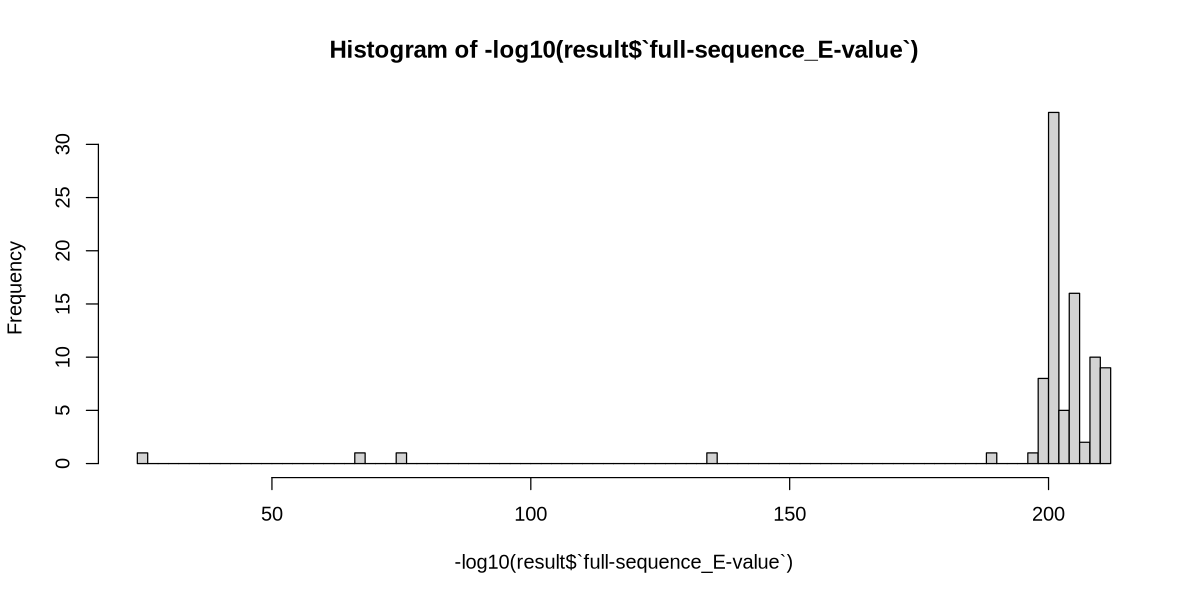

In [171]:
# Annotate Aat genes in test set
options(repr.plot.width=10, repr.plot.height=5)

## Create output directory
out_ann <- paste0(out_path, 'predict_on_validation/')
dir.create(out_ann)

## Select gene type
i <- 'Aat'

## Set variables
clean_i <- str_remove(i, " ")
fn.faa <- paste0(out_ann,clean_i,'.faa')
fn.ali <- paste0(out_ann,clean_i,'_aligned.fasta')
fn.hmm <- paste0(out_ann,clean_i,'_profile.hmm')
fn.result <- paste0(out_ann,clean_i,'_hmmsearch.result')

## Filter
sel <- data %>% filter(ann_level_1 == i)

## Format
aa <- sel$protein_seq
names(aa) <- sel$Name
aa <- AAStringSet(aa)

## Write to file
writeXStringSet(aa, fn.faa)

## Run MSA
msa_call <- paste0('muscle -align ',fn.faa,' -output ',fn.ali)
system(msa_call, intern=TRUE)

## Build profile HMM
hmmbuild <- paste0('hmmbuild ',fn.hmm,' ',fn.ali)
system(hmmbuild, intern=TRUE)

## HMM search
hmmsearch <- paste0('hmmsearch -o ',fn.result,' ',fn.hmm,' ',fs$validation$protein)
system(hmmsearch, intern=TRUE)

## Read output
result <- read_HMMsearch(fn.result)

## Investigate hit distribution
hist(-log10(result$`full-sequence_E-value`), breaks = 100)

## Filter significant results
index <- which(result$`full-sequence_E-value` < 1e-10)
result <- result[index, ]

In [172]:
# Annotate Aat genes in validation set

## Create empty annotation
validation$features$ann_level_1 <- NA

## Annotate Aat genes
index <- which(validation$features$Gene.CDS.Protein.FASTA.Sequence.ID %in% result$Sequence)
validation$features$ann_level_1[index] <- 'Aat'

## Quantify Aat genes per genome
x <- validation$features %>% group_by(Accession) %>% summarize(Aat = sum(ann_level_1 == 'Aat', na.rm = TRUE))
table(x$Aat)


 0  1  2  3 
25 42 22  1 

In [173]:
table(data$ann_level_1)


       Other      dCTPase        HMase  dNMP kinase      DNA pol      Ara iso 
        9346           13            9            8          119           37 
NTP transfer Glu transfer          Aat      Thy syn      Thy kin 
           2           12           26           51           18 

Warning message in dir.create(out_ann):
“'analysis/2025-01-09/predict_on_test' already exists”


character(0)

[1] "# hmmbuild :: profile HMM construction from multiple sequence alignments"                 
 [2] "# HMMER 3.4 (Aug 2023); http://hmmer.org/"                                                
 [3] "# Copyright (C) 2023 Howard Hughes Medical Institute."                                    
 [4] "# Freely distributed under the BSD open source license."                                  
 [5] "# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -"                
 [6] "# input alignment file:             analysis/2025-01-09/predict_on_test/Aat_aligned.fasta"
 [7] "# output HMM file:                  analysis/2025-01-09/predict_on_test/Aat_profile.hmm"  
 [8] "# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -"                
 [9] ""                                                                                         
[10] "# idx name                  nseq  alen  mlen eff_nseq re/pos description"                 
[11] "#---- -------------------- ----- ----- ----- -------- ------ -----------"                 
[12] "1     Aat_aligned             26   375   373     0.62  0.590 "                            
[13] ""                                                                                         
[14] "# CPU time: 0.14u 0.00s 00:00:00.14 Elapsed: 00:00:00.14"

character(0)

Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 109”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”


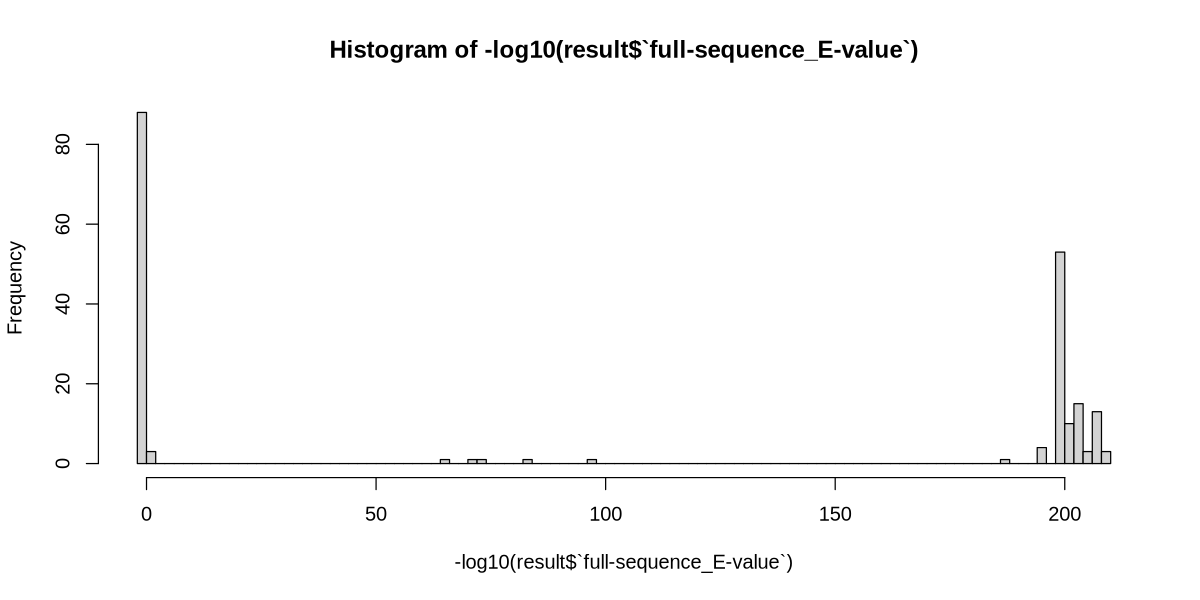

In [174]:
# Annotate Aat genes in test set
options(repr.plot.width=10, repr.plot.height=5)

## Create output directory
out_ann <- paste0(out_path, 'predict_on_test/')
dir.create(out_ann)

## Select gene type
i <- 'Aat'

## Set variables
clean_i <- str_remove(i, " ")
fn.faa <- paste0(out_ann,clean_i,'.faa')
fn.ali <- paste0(out_ann,clean_i,'_aligned.fasta')
fn.hmm <- paste0(out_ann,clean_i,'_profile.hmm')
fn.result <- paste0(out_ann,clean_i,'_hmmsearch.result')

## Filter
sel <- data %>% filter(ann_level_1 == i)

## Format
aa <- sel$protein_seq
names(aa) <- sel$Name
aa <- AAStringSet(aa)

## Write to file
writeXStringSet(aa, fn.faa)

## Run MSA
msa_call <- paste0('muscle -align ',fn.faa,' -output ',fn.ali)
system(msa_call, intern=TRUE)

## Build profile HMM
hmmbuild <- paste0('hmmbuild ',fn.hmm,' ',fn.ali)
system(hmmbuild, intern=TRUE)

## HMM search
hmmsearch <- paste0('hmmsearch -o ',fn.result,' ',fn.hmm,' ',fs$test$protein)
system(hmmsearch, intern=TRUE)

## Read output
result <- read_HMMsearch(fn.result)

## Investigate hit distribution
hist(-log10(result$`full-sequence_E-value`), breaks = 100)

## Filter significant results
index <- which(result$`full-sequence_E-value` < 1e-10)
result <- result[index, ]

In [175]:
# Annotate Aat genes in test set

## Create empty annotation
test$features$ann_level_1 <- NA

## Annotate Aat genes
index <- which(test$features$Gene.CDS.Protein.FASTA.Sequence.ID %in% result$Sequence)
test$features$ann_level_1[index] <- 'Aat'

## Quantify Aat genes per genome
x <- test$features %>% group_by(Accession) %>% summarize(Aat = sum(ann_level_1 == 'Aat', na.rm = TRUE))
table(x$Aat)


    0     1     2     3 
37142    56    24     1 

character(0)

[1] "# hmmbuild :: profile HMM construction from multiple sequence alignments"                  
 [2] "# HMMER 3.4 (Aug 2023); http://hmmer.org/"                                                 
 [3] "# Copyright (C) 2023 Howard Hughes Medical Institute."                                     
 [4] "# Freely distributed under the BSD open source license."                                   
 [5] "# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -"                 
 [6] "# input alignment file:             analysis/2025-01-09/predict_on_test2/Aat_aligned.fasta"
 [7] "# output HMM file:                  analysis/2025-01-09/predict_on_test2/Aat_profile.hmm"  
 [8] "# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -"                 
 [9] ""                                                                                          
[10] "# idx name                  nseq  alen  mlen eff_nseq re/pos description"                  
[11] "#---- -------------------- ----- ----- ----- -------- ------ -----------"                  
[12] "1     Aat_aligned             26   375   373     0.62  0.590 "                             
[13] ""                                                                                          
[14] "# CPU time: 0.13u 0.00s 00:00:00.13 Elapsed: 00:00:00.14"

character(0)

Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 68”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”


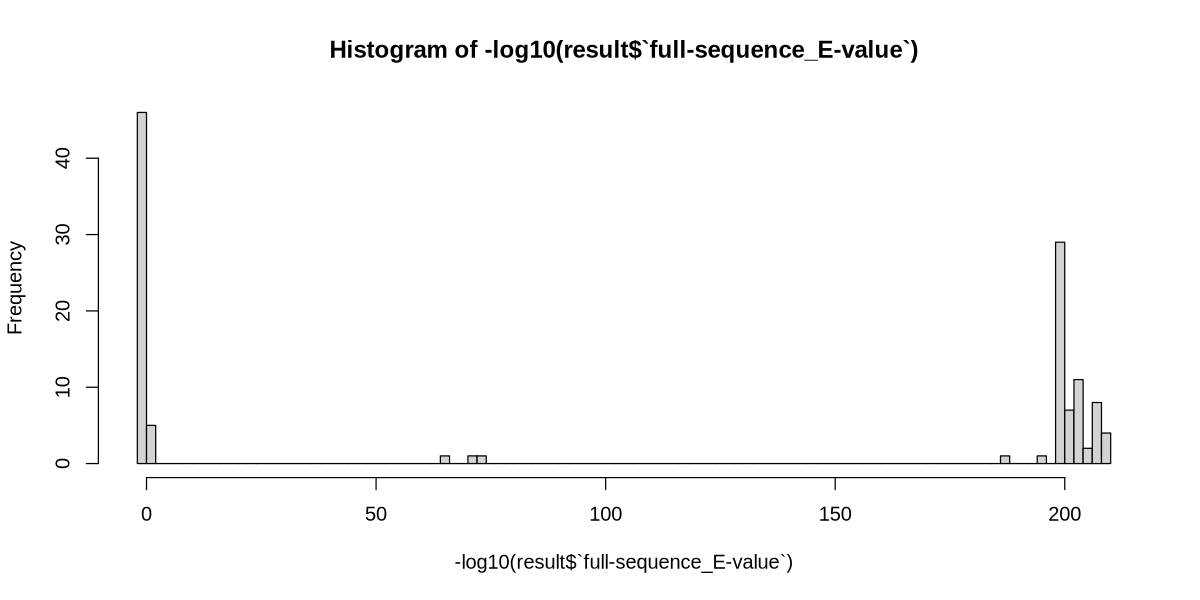

In [176]:
# Annotate Aat genes in test set
options(repr.plot.width=10, repr.plot.height=5)

## Create output directory
out_ann <- paste0(out_path, 'predict_on_test2/')
dir.create(out_ann)

## Select gene type
i <- 'Aat'

## Set variables
clean_i <- str_remove(i, " ")
fn.faa <- paste0(out_ann,clean_i,'.faa')
fn.ali <- paste0(out_ann,clean_i,'_aligned.fasta')
fn.hmm <- paste0(out_ann,clean_i,'_profile.hmm')
fn.result <- paste0(out_ann,clean_i,'_hmmsearch.result')

## Filter
sel <- data %>% filter(ann_level_1 == i)

## Format
aa <- sel$protein_seq
names(aa) <- sel$Name
aa <- AAStringSet(aa)

## Write to file
writeXStringSet(aa, fn.faa)

## Run MSA
msa_call <- paste0('muscle -align ',fn.faa,' -output ',fn.ali)
system(msa_call, intern=TRUE)

## Build profile HMM
hmmbuild <- paste0('hmmbuild ',fn.hmm,' ',fn.ali)
system(hmmbuild, intern=TRUE)

## HMM search
hmmsearch <- paste0('hmmsearch -o ',fn.result,' ',fn.hmm,' ',fs$test2$protein)
system(hmmsearch, intern=TRUE)

## Read output
result <- read_HMMsearch(fn.result)

## Investigate hit distribution
hist(-log10(result$`full-sequence_E-value`), breaks = 100)

## Filter significant results
index <- which(result$`full-sequence_E-value` < 1e-10)
result <- result[index, ]

In [177]:
# Annotate Aat genes in validation set

## Create empty annotation
test2$features$ann_level_1 <- NA

## Annotate Aat genes
index <- which(test2$features$Gene.CDS.Protein.FASTA.Sequence.ID %in% result$Sequence)
test2$features$ann_level_1[index] <- 'Aat'

## Quantify Aat genes per genome
x <- test2$features %>% group_by(Accession) %>% summarize(Aat = sum(ann_level_1 == 'Aat', na.rm = TRUE))
table(x$Aat)


    0     1     2     3 
23607    29    17     1 

In [67]:
# Investigate genomes with three Aat genes

## Retrieve GTF entries
index <- which(ds_all$annotation$Accession %in% x$Accession[which(x$Aat == 3)])
sel <- ds_all$annotation[index, ]

Warning message:
“Removed 38 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


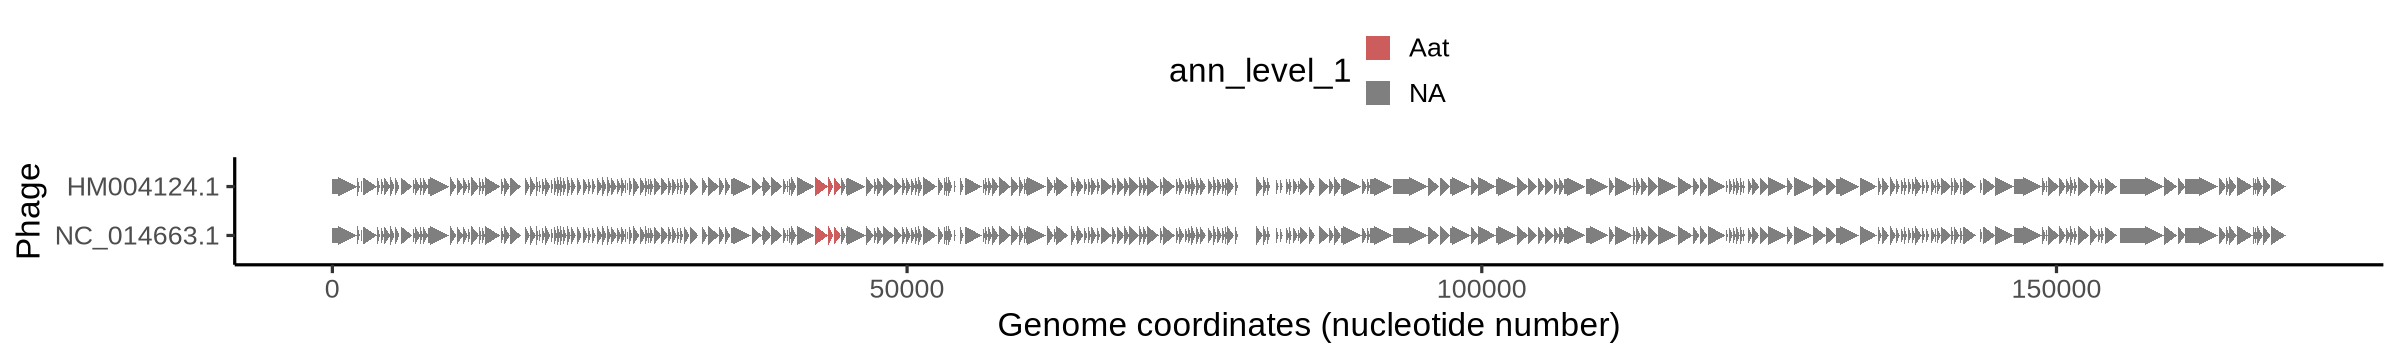

In [76]:
# Visualize genomes
options(repr.plot.width=20, repr.plot.height=3)

## Fetch data
df <- sel

## Create annotations
ann <- df %>% select(Accession) %>% unique()

## Order
df$Accession <- factor(df$Accession, unique(df$Accession))

# Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Accession, fill = ann_level_1), col=NA
                   ) +
    scale_fill_manual(values = cols$ann_level_1) +
    theme_classic(20) +
    guides(fill = guide_legend(position = 'top', nrow=2), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates (nucleotide number)", y = "Phage")

In [80]:
str(ds_core, max.level = 1)

List of 4
 $ accession : chr [1:35] "OP617331.1" "AF158101.6" "NC_004928.1" "MZ501056.1" ...
 $ metadata  :'data.frame':	35 obs. of  49 variables:
 $ annotation:'data.frame':	9641 obs. of  72 variables:
 $ protein   :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots


In [196]:
options(repr.plot.width=12, repr.plot.height=6)

index <- which(data$ann_level_1 == 'Aat')
aa <- data$protein_seq[index]

# Distance matrix
dist <- dist.gene(as.AAbin(result))
#dist <- minmax(dist)

# Tree
tree <- nj(dist)

# Plot
ggtree(tree) +
    geom_point(aes(col=label), size = 5) +
    geom_tiplab(size=6, hjust = -0.1) +
    theme(
        text = element_text(size = 20)
    ) +
    guides(
        col = guide_none()
    ) +
    geom_rootedge(0.15) +
    expand_limits(x = c(0, 2)) +
    labs(title='MSA tree of tape measure proteins')

ERROR: Error in nj(dist): cannot build an NJ tree with less than 3 observations


In [197]:
dist

   1
2 10

In [101]:
# Geographic location
unique(report$Geographic.Location)

[1] ""                                                                                                             
   [2] "USA"                                                                                                          
   [3] "China: Korla"                                                                                                 
   [4] "China"                                                                                                        
   [5] "USA: Edinburg, VA"                                                                                            
   [6] "USA: Harrisonburg, VA"                                                                                        
   [7] "India"                                                                                                        
   [8] "Germany: Berlin"                                                                                              
   [9] "Spain"                                                                                                        
  [10] "Germany"                                                                                                      
  [11] "China: Inner Mongolia Hohhot"                                                                                 
  [12] "USA: North Carolina"                                                                                          
  [13] "Kenya"                                                                                                        
  [14] "Japan"                                                                                                        
  [15] "India: Visakhapatnam"                                                                                         
  [16] "Iran"                                                                                                         
  [17] "USA: South Carolina"                                                                                          
  [18] "Malaysia"                                                                                                     
  [19] "Viet Nam"                                                                                                     
  [20] "USA: Poolesville, MD"                                                                                         
  [21] "USA: Tennessee"                                                                                               
  [22] "Slovakia"                                                                                                     
  [23] "Taiwan"                                                                                                       
  [24] "Ireland: Cork"                                                                                                
  [25] "Turkey"                                                                                                       
  [26] "Thailand"                                                                                                     
  [27] "South Korea"                                                                                                  
  [28] "Egypt"                                                                                                        
  [29] "USA: Clear Creek, League City, TX"                                                                            
  [30] "Italy"                                                                                                        
  [31] "India: Ludhiana (Punjab)"                                                                                     
  [32] "Mexico"                                                                                                       
  [33] "USA: Rindge, NH"                                                                                              
  [34] "Sweden"                                                             

In [20]:
## Investigate data report

# Read data report
report <- as.list(readLines(ncbi$data_report, skipNul = TRUE))
report <- lapply(report, fromJSON)

# Re-format
for (n in 1:length(report)) {
    x <- report[[n]]
    report[[n]] <- data.frame(
    accession = get_list_entry(x[["accession"]]),
    virusName = get_list_entry(x[["virus"]][["organismName"]]),
    virusClass = get_list_entry(x[["virus"]][["lineage"]][["name"]][[5]]),
    virusGenus = get_list_entry(x[["virus"]][["lineage"]][["name"]][[6]]),
    completeness = get_list_entry(x[["completeness"]]),
    geneCount = get_list_entry(x[["geneCount"]]),
    genomeSize = get_list_entry(x[["length"]]),
    geoLocation = get_list_entry(x[["location"]][["geographicLocation"]]),
    geoRegion = get_list_entry(x[["location"]][["geographicRegion"]]),
    labHost = get_list_entry(x[["labHost"]])
    )
}
report <- bind_rows(report)

# Check accession numbers
all(data$accession %in% report$accession)
all(report$accession %in% data$accession)

[1] FALSE

[1] FALSE

In [25]:
## Add additional information

# Read genomes
genome <- readDNAStringSet(ncbi$genomic)
names(genome) <- str_split(names(genome), ',',simplify=TRUE)[,1]

# Mutate report
report$key <- paste(report$accession, report$virusName)
report$genomePresent <- names(genome) %in% report$key
report$genomeIndex <- match(names(genome), report$key)

In [26]:
## Investigate report
x <- data$accession %in% report$accession
table(x)
data$accession[!x]

x
FALSE  TRUE 
    3    31 

[1] "NC_028683.1" "NC_055721.1" "NC_055727.1"

In [29]:
## Investigate report

# Dimensions
x <- table(report$genomePresent)
message(paste0("Genomes present \n", "True: ", x[[2]], ", False: ", x[[1]]))
message(paste(ncol(report), "Annotations"))

# View
rbind(head(report,3), tail(report,3))

# Check absence of NAs in important columns
message(paste("Any missing accession:", any(is.na(report$accession))))
message(paste("Any missing virusName:", any(is.na(report$virusName))))

Genomes present 
True: 20940, False: 4859

13 Annotations



,accession,virusName,virusClass,virusGenus,completeness,geneCount,genomeSize,geoLocation,geoRegion,labHost,key,genomePresent,genomeIndex
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<lgl>,<int>
1,OP073944.1,Bacteriophage sp.,NA,NA,COMPLETE,21,22014,Japan,Asia,NA,OP073944.1 Bacteriophage sp.,TRUE,4501
2,OP073957.1,Bacteriophage sp.,NA,NA,COMPLETE,15,17138,Japan,Asia,NA,OP073957.1 Bacteriophage sp.,TRUE,4502
3,OP073961.1,Bacteriophage sp.,NA,NA,COMPLETE,32,31550,Japan,Asia,NA,OP073961.1 Bacteriophage sp.,TRUE,4503
25797,EU855793.1,Listeria phage P40,Caudoviricetes,unclassified Caudoviricetes,COMPLETE,62,35638,Switzerland,Europe,NA,EU855793.1 Listeria phage P40,FALSE,NA
25798,EU861004.1,Staphylococcus phage vB_SauS-phiIPLA88,Caudoviricetes,Azeredovirinae,COMPLETE,61,42526,NA,NA,NA,EU861004.1 Staphylococcus phage vB_SauS-phiIPLA88,FALSE,NA
25799,EU861005.1,Staphylococcus phage phiSauS-IPLA35,Caudoviricetes,Triavirus,COMPLETE,62,45344,NA,NA,NA,EU861005.1 Staphylococcus phage phiSauS-IPLA35,FALSE,NA


Any missing accession: FALSE

Any missing virusName: FALSE



In [30]:
## Save report
write.table(report, genomes$overview, sep = ",")

In [32]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 9.2 (Blue Onyx)

Matrix products: default
BLAS/LAPACK: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Pacific/Auckland
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Biostrings_2.70.1   GenomeInfoDb_1.38.1 XVector_0.42.0     
 [4] IRanges_2.36.0      S4Vectors_0.40.2    BiocGenerics_0.48.1
 [7] jsonlite_1.8.9      tidyr_1.3.1         